Welcome to the HDMM_NN Tutorial! For an overview of what HDDM is about, as well as installation instructions, 
visit the github page of this tutorial.

In [1]:
# TODO: PRERUN MCMC SAMPLING AND STORE TRACES IN DATA_STORAGE/TRACES/
# SO WE HAVE THE CHANCE TO FORGO SAMPLING

In [ ]:
# INSTALLATION COLAB:
# !pip install pymc
# !pip install kabuki


In [5]:
# Module imports
import hddm
import sys
import pandas as pd
import numpy as np
import sys
import pickle
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('simulators')
import cddm_data_simulation as cds
import boundary_functions as bf

from helper_functions import simulator
from helper_functions import model_plot
from helper_functions import caterpillar_plot
from helper_functions import posterior_pair_plot
from helper_functions import hddm_preprocess_hierarchical
from helper_functions import simulator_condition_effects
from helper_functions import make_parameter_sets
# posterior predictive plot
# caterpillar plot
from helper_functions import _make_trace_plotready_condition

from helper_functions import hddm_preprocess

# Section 1: A look into DDM variations
Let's simulate some data from the angle model and check the resulting (choice, reaction) time data.
You can change the number of samples (n_samples), and the parameters of the model (v, a, w, ndt, theta). 
If you are outside of the valid range for any parameter you will be warned. First, let's begin with the angle model, in which the decision bound $a$ is a line making an angle $\theta$ with the $y$ axis.

## Angle model
In the angle model, we have 5 parameters:
- $a$, a boundary scalar. $a$ reflects how much relative evidence one would need to reach a certain choice. The higher $a$ is, the more evidence is needed in favor of one option over the other, before a choice is taken. An example of a way to expect higher $a$ value would be to tell the participant to 'be as prudent and accurate as possible'.
- $v$, drift, or evidence for/against a certain choice. Note that as a task becomes more difficult, $v$ could decrease.
- $w$, bias, accounts for an a priori preference towards a choice compared to the other (a reason for this might be an imbalance or otherwise detected pattern in the stimulus set
- $t$, non-decision time, a 'lag' before the participant begins processing task relevant information.
- $\theta$, the angle parameter, which gives the degree of 'collapse of the bounds'.

### make_parameter_sets (model, n_parameter_sets, param_dict)
Parameters:
- **model**: string, 'ddm', 'angle' or 'weibull_cdf'
- **n_parameter_sets**: integer, the number of parameter sets desired.
- **param_dict**: a dictionary containing any specific parameters. For example, `param_dict = {'v': [1]}` will make all the parameter sets have $v$ = 1. Can be used in combination with list comprehension and `np.linspace` to produce jumps. For example, `{'v' = [i for i in np.linspace(0.5, 1.5, 5)]}` causes $v$ to increase from 0.5 to 1.5 in 5 steps.

Returns:
A `pandas` frame consisting of the parameter sets. To access the $n$-th parameter set as an array, call `values[n]`.


In [24]:
# LETS START WITH MAKING SOME PARAMETERS FOR OUR MODEL OF CHOICE

angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 5,
                                   param_dict = {'v': [i for i in np.linspace(0.5, 1.5, 5)]})

In [25]:
angle_params.values[0]

array([0.5       , 1.19997586, 0.57617879, 1.71756698, 0.31328966])

### simulator(model, theta, n_samples)
Parameters:
- **model**: string, 'ddm', 'angle' or 'weibull_cdf'
- **theta**: an array in the output of `make_parameter_sets`. Automatically handles theta/alpha/beta in the case of angle/weibull models. 
- **n_samples**: integer.

Returns:
A 3-tupule of:
0. An array of time data
1. An array of choice data
2. Metadata

In [26]:
simulations = simulator(theta = angle_params.values[0],
                        model = 'angle', 
                        n_samples = 2000)

In [27]:
# Look into the output
simulations

(array([[2.462561 ],
        [2.1595647],
        [2.2475638],
        ...,
        [2.1695647],
        [3.6566014],
        [2.135565 ]], dtype=float32),
 array([[ 1],
        [ 1],
        [ 1],
        ...,
        [ 1],
        [-1],
        [ 1]], dtype=int32),
 {'v': 0.5,
  'a': 1.199975848197937,
  'w': 0.576178789138794,
  'ndt': 1.717566967010498,
  's': 1.0,
  'theta': 0.31328965799805875,
  'delta_t': 0.0010000000474974513,
  'max_t': 20.0,
  'n_samples': 2000,
  'simulator': 'ddm_flexbound',
  'boundary_fun_type': 'angle',
  'possible_choices': [-1, 1]})

Now that we have our simulated data, we look to visualise it.
## Plotting a sample dataset
### model_plot(ground_truths, posterior_samples, cols, model_gy, datatype, n_plots, max_t, show_model)

Parameters:

- **ground_truths**: arrays of ground truth parameters
- **posterior_samples**: posterior data. For now, leave this as `None` since we are only plotting our simulated data.
- **cols**: integer, number of columns of plots. Only relevant when plotting multiple plots.
- **n_plots**: integer, number of plots
- **model_gt**: string, 'ddm', 'angle' or 'weibull_cdf'. The model from which the ground truth data came from.
- **datatype**: string, 'single_subject', 'hierarchical' or 'condition'
- **max_t**: float, maximum reaction time shown
- **show_model**: bool, whether or not the parameter lines are shown

Return:

Plot of the appropriate information.

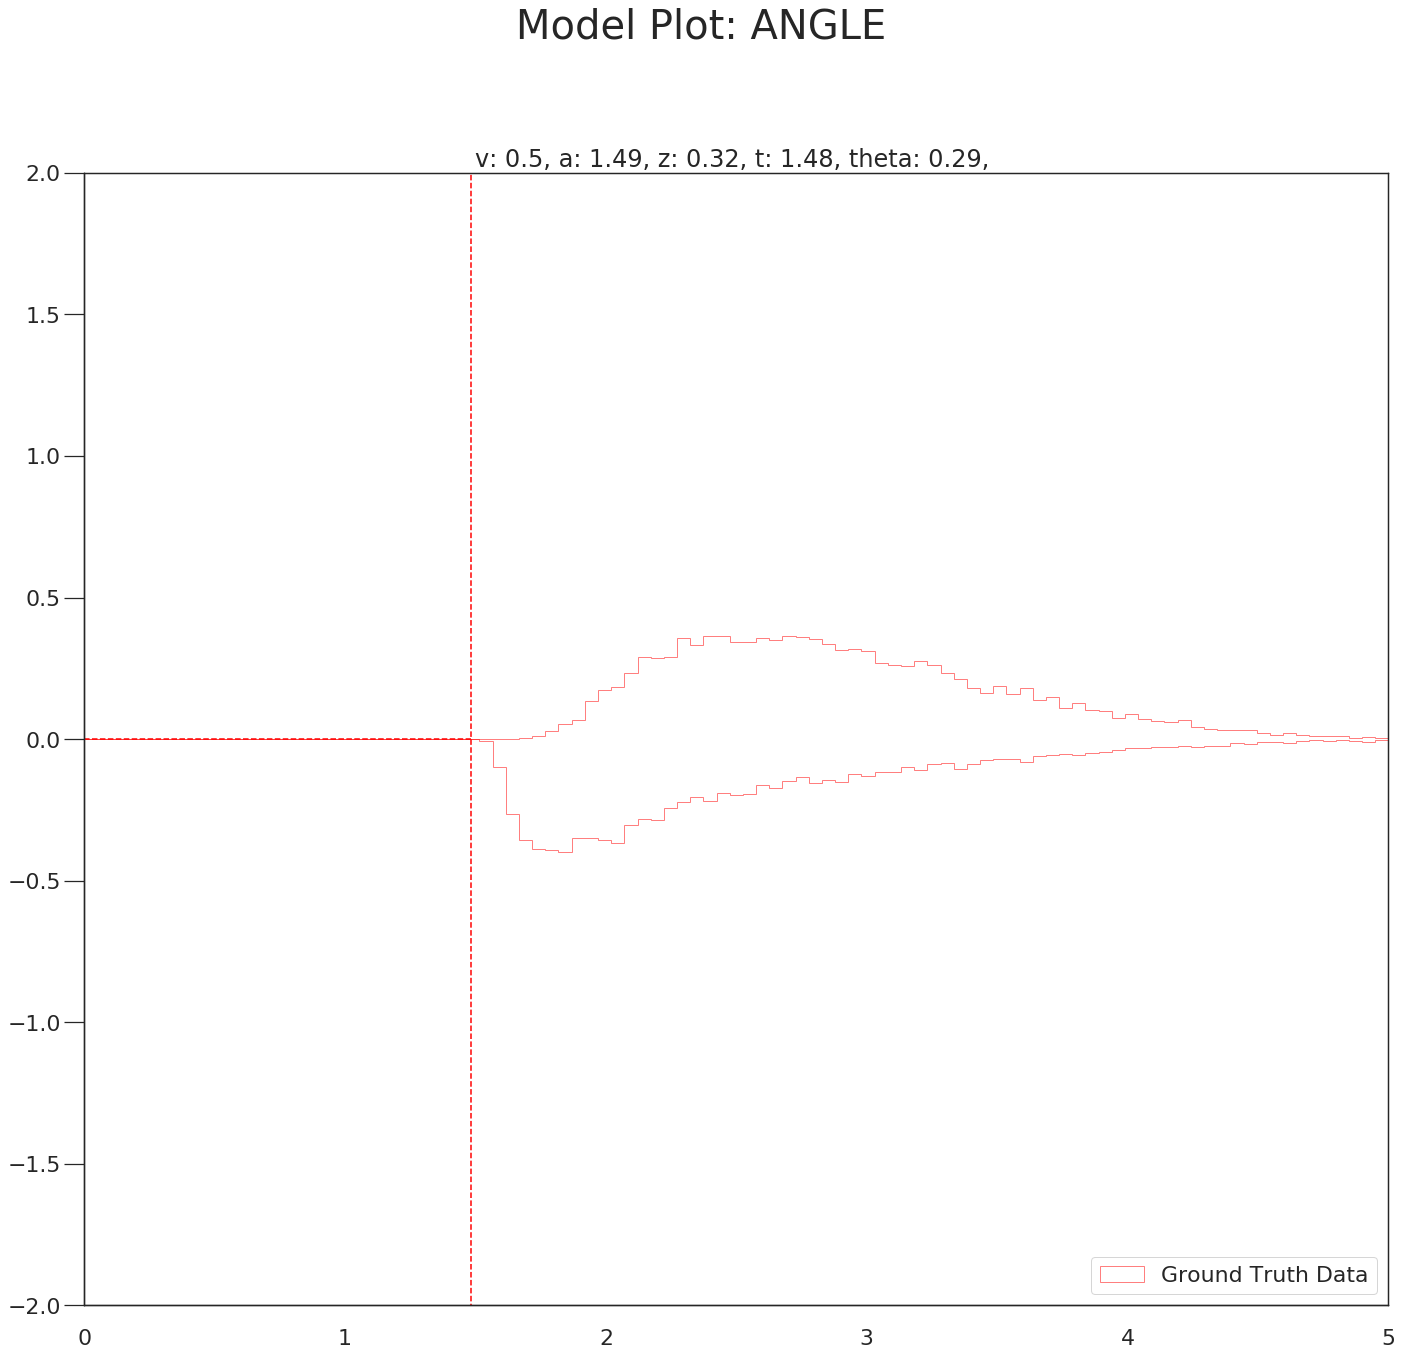

In [9]:
# Model Plots (Only data)
model_plot(ground_truths = angle_params.values[0],
           posterior_samples = None,
           cols = 1, 
           model_gt = 'angle',
           datatype = 'single_subject',
           n_plots = 1,
           max_t = 5,
           show_model = False)

### The Effect of varying parameters

#### varying $a$

We look to investigate the ground truth data distribution when one parameter is changed very slightly. First, let's look at what happens for the angle model when $a$ varies from 0.5 to 1.5 in ten steps.

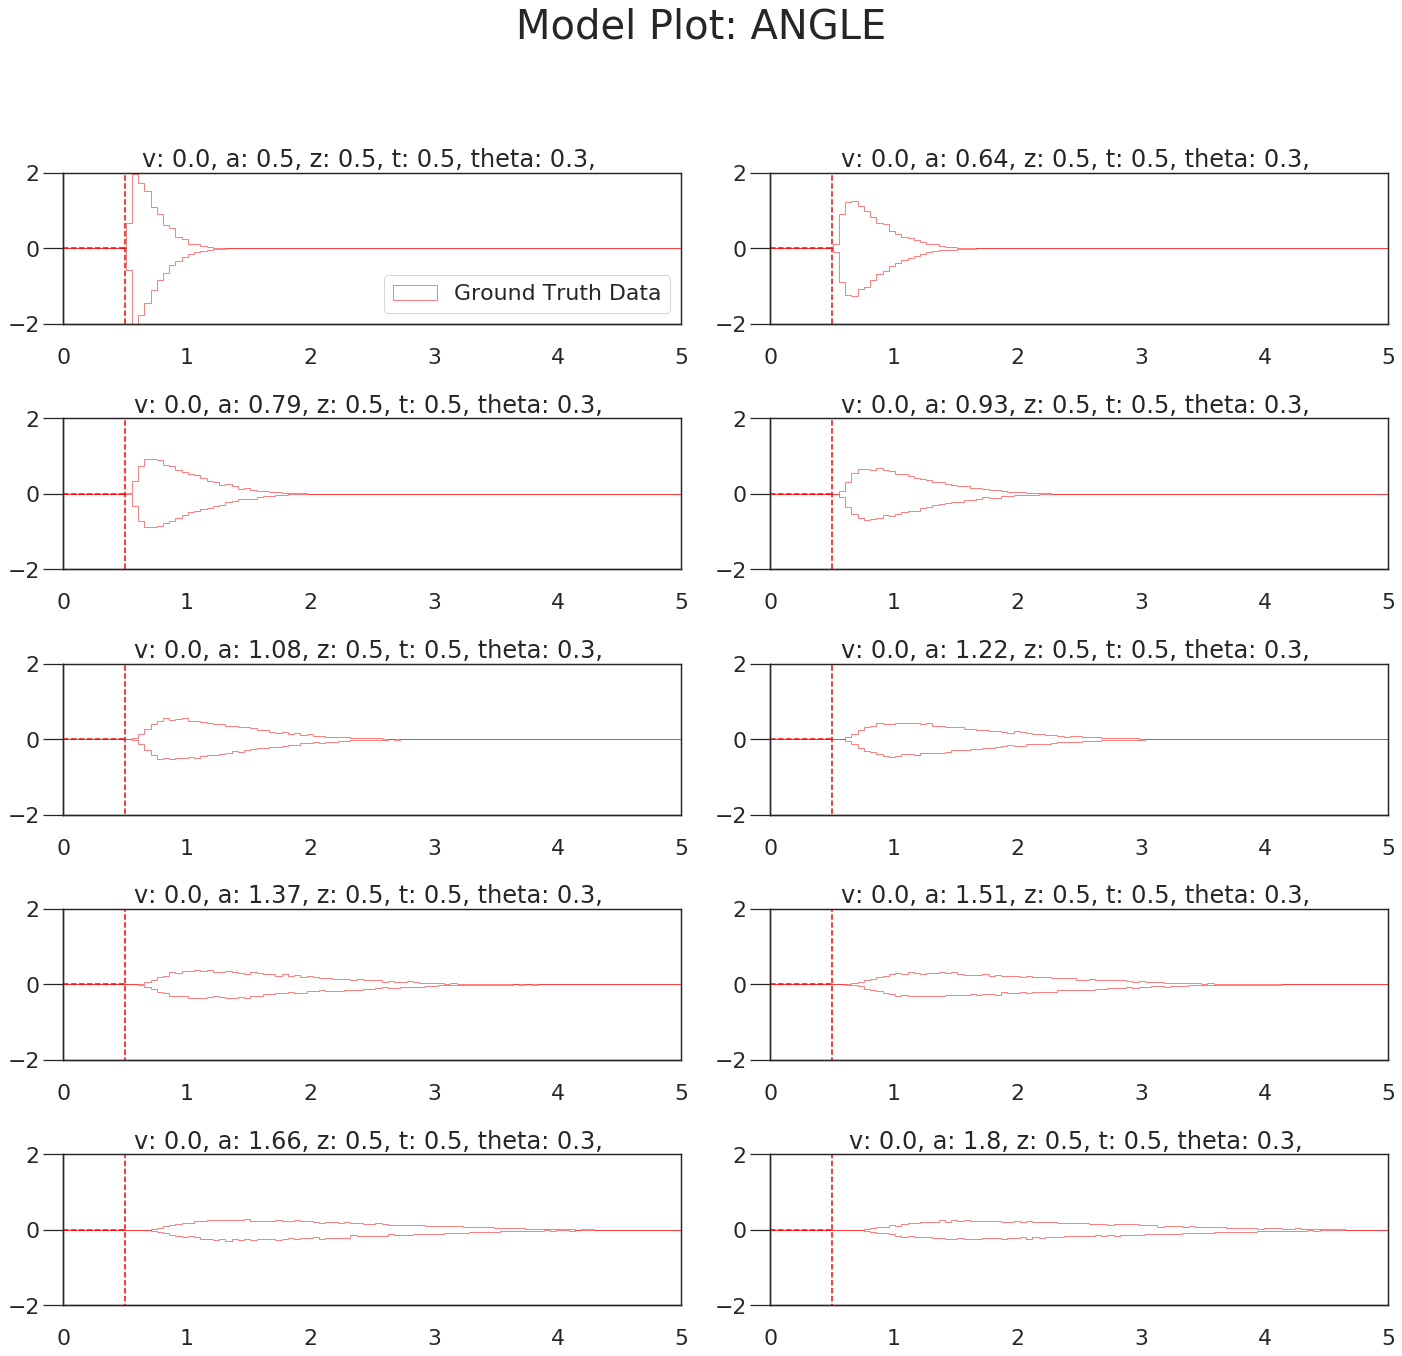

In [14]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [i for i in np.linspace(0.5, 1.8, 10)],
                                                 'v': [0],
                                                 'z': [0.5],
                                                 'theta': [0.3],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

Note that as $a$ increases, the data distribution becomes flatter and wider, or the participant is more likely to take very long before reaching a choice. This makes sense because as $a$ increases, more evidence is required before a choice is made, leading to long reaction times. For small $a$ values, little evidence is required and thus most of the reaction time is short. 

Now let us fix the other parameters and vary $\theta$ instead, to see how this affects the **choice/reaction-time** distributions.

#### varying $\theta$ 

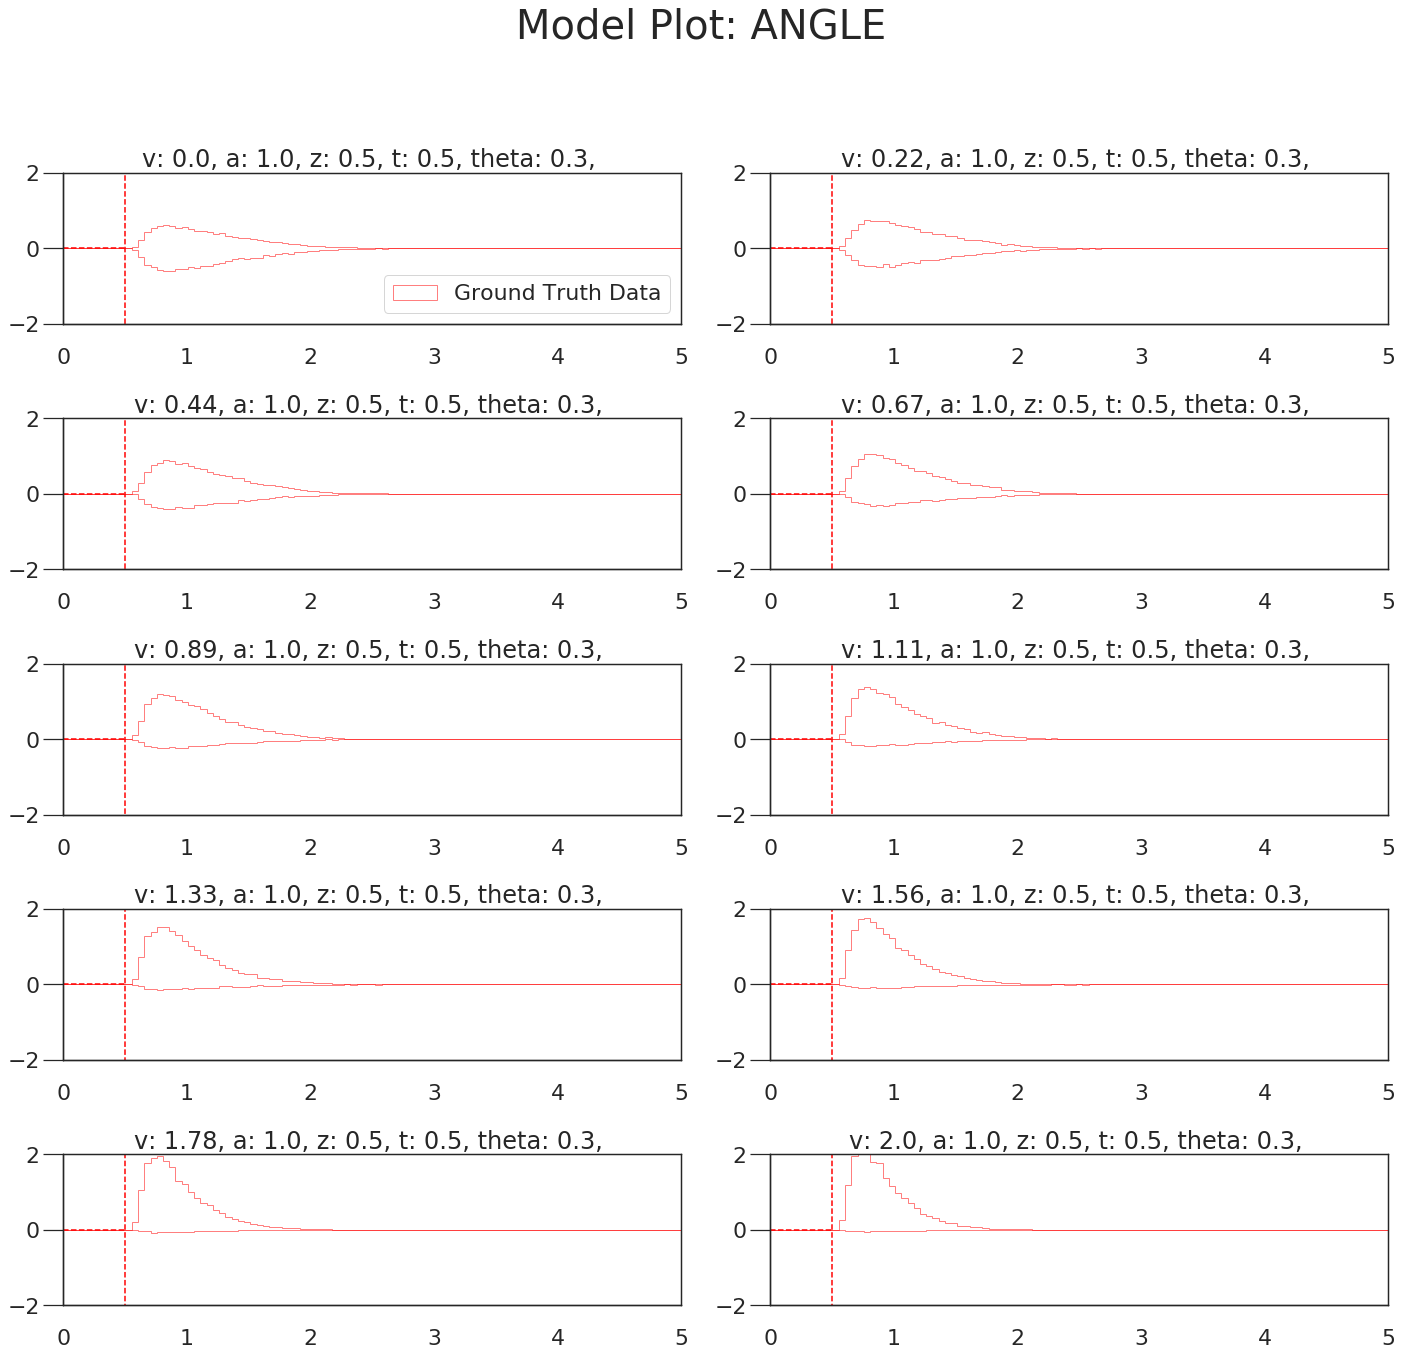

In [21]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.0],
                                                 'v': [0.5],
                                                 'z': [0.55],
                                                 'theta': [i for i in np.linspace(0.2, 1.0, 10)],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

### Adding the ground truth model visually

We can include the ground truth model itself pictorially to aid intuition.

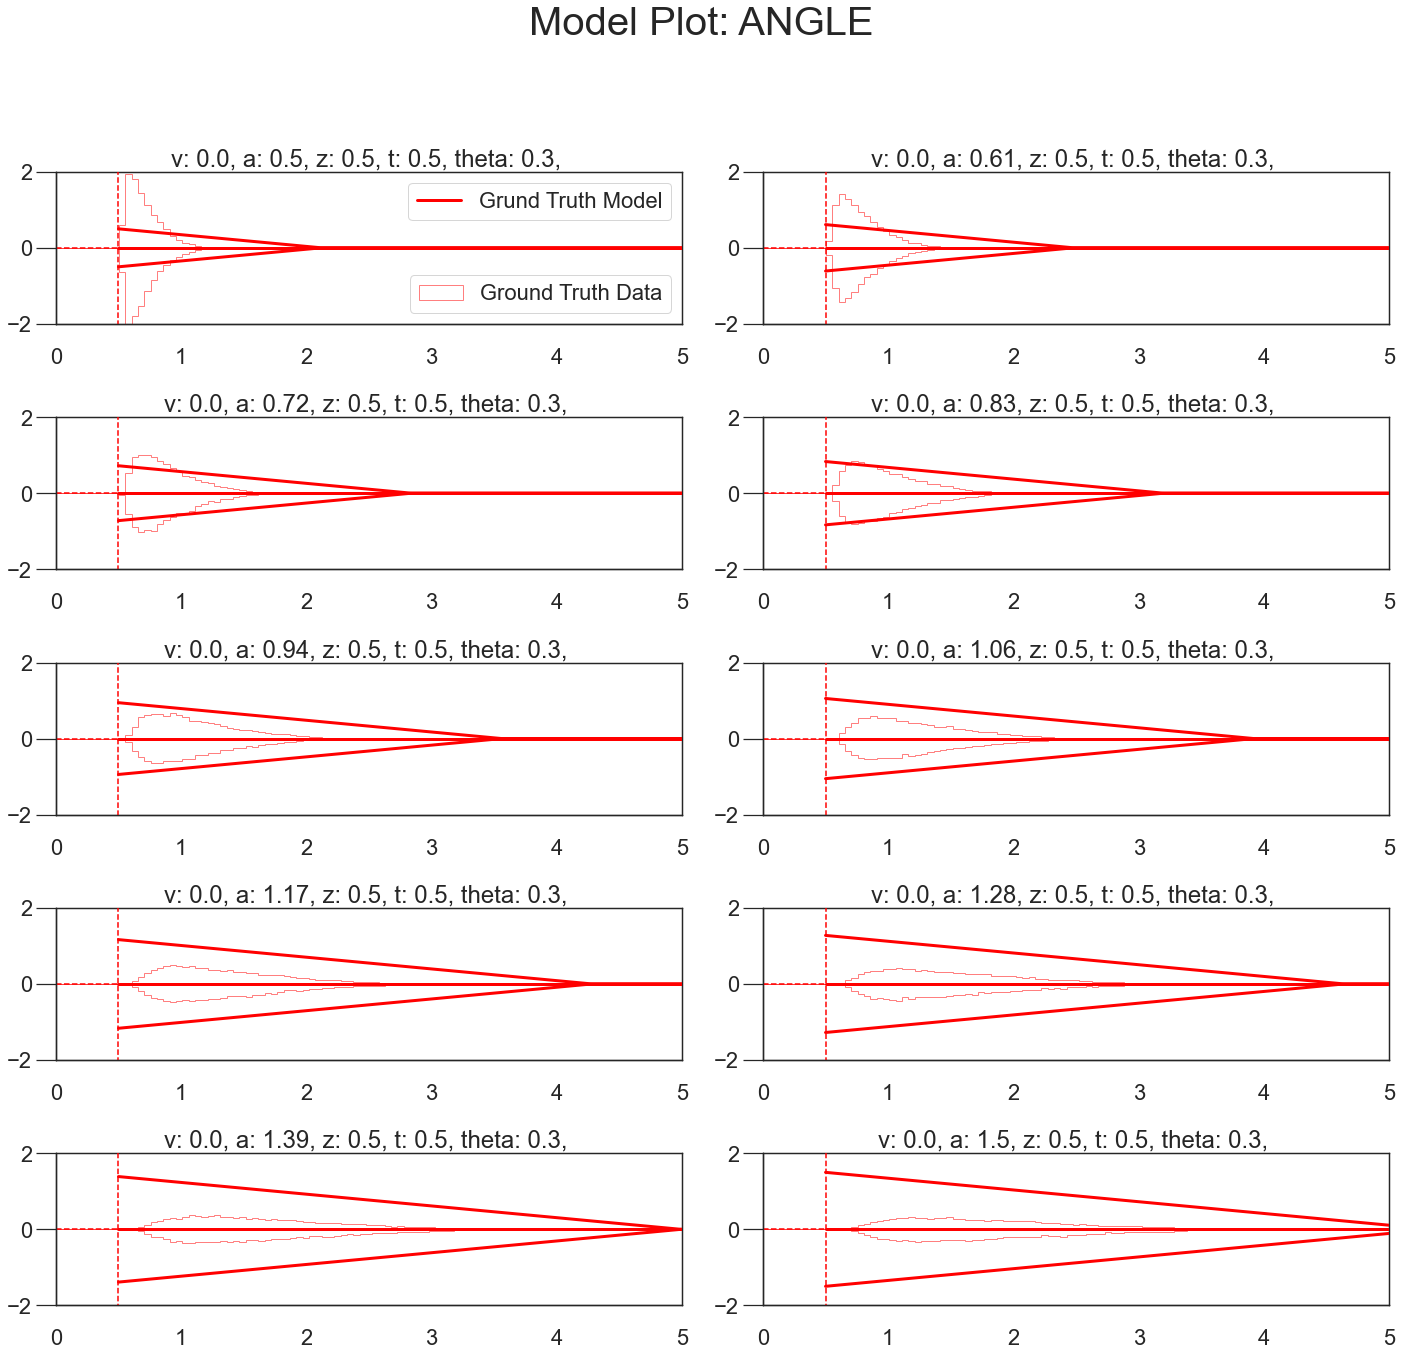

In [44]:
# Model Plot (Data + Model)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = True)

If you are interested, you can use this code to investigate the effects of the other parameters.

## WEIBULL CDF MODEL
In the **weibull cdf** model, we have $6$ parameters:
- $a$, a boundary scalar. $a$ reflects how much relative evidence one would need to reach a certain choice. The higher $a$ is, the more evidence is needed in favor of one option over the other, before a choice is taken. An example of a way to expect higher $a$ value would be to tell the participant to 'be as prudent and accurate as possible'.
- $v$, drift, or evidence for/against a certain choice. Note that as a task becomes more difficult, $v$ could decrease.
- $w$, bias, accounts for an a priori preference towards a choice compared to the other (a reason for this might be an imbalance or otherwise detected pattern in the stimulus set
- $t$, non-decision time, a 'lag' before the participant begins processing task relevant information.
- $\alpha$ and $\beta$, two parameters which jointly define the 'shape of the bounds'.

Let us quickly look into the effects of $\alpha$ and $\beta$.

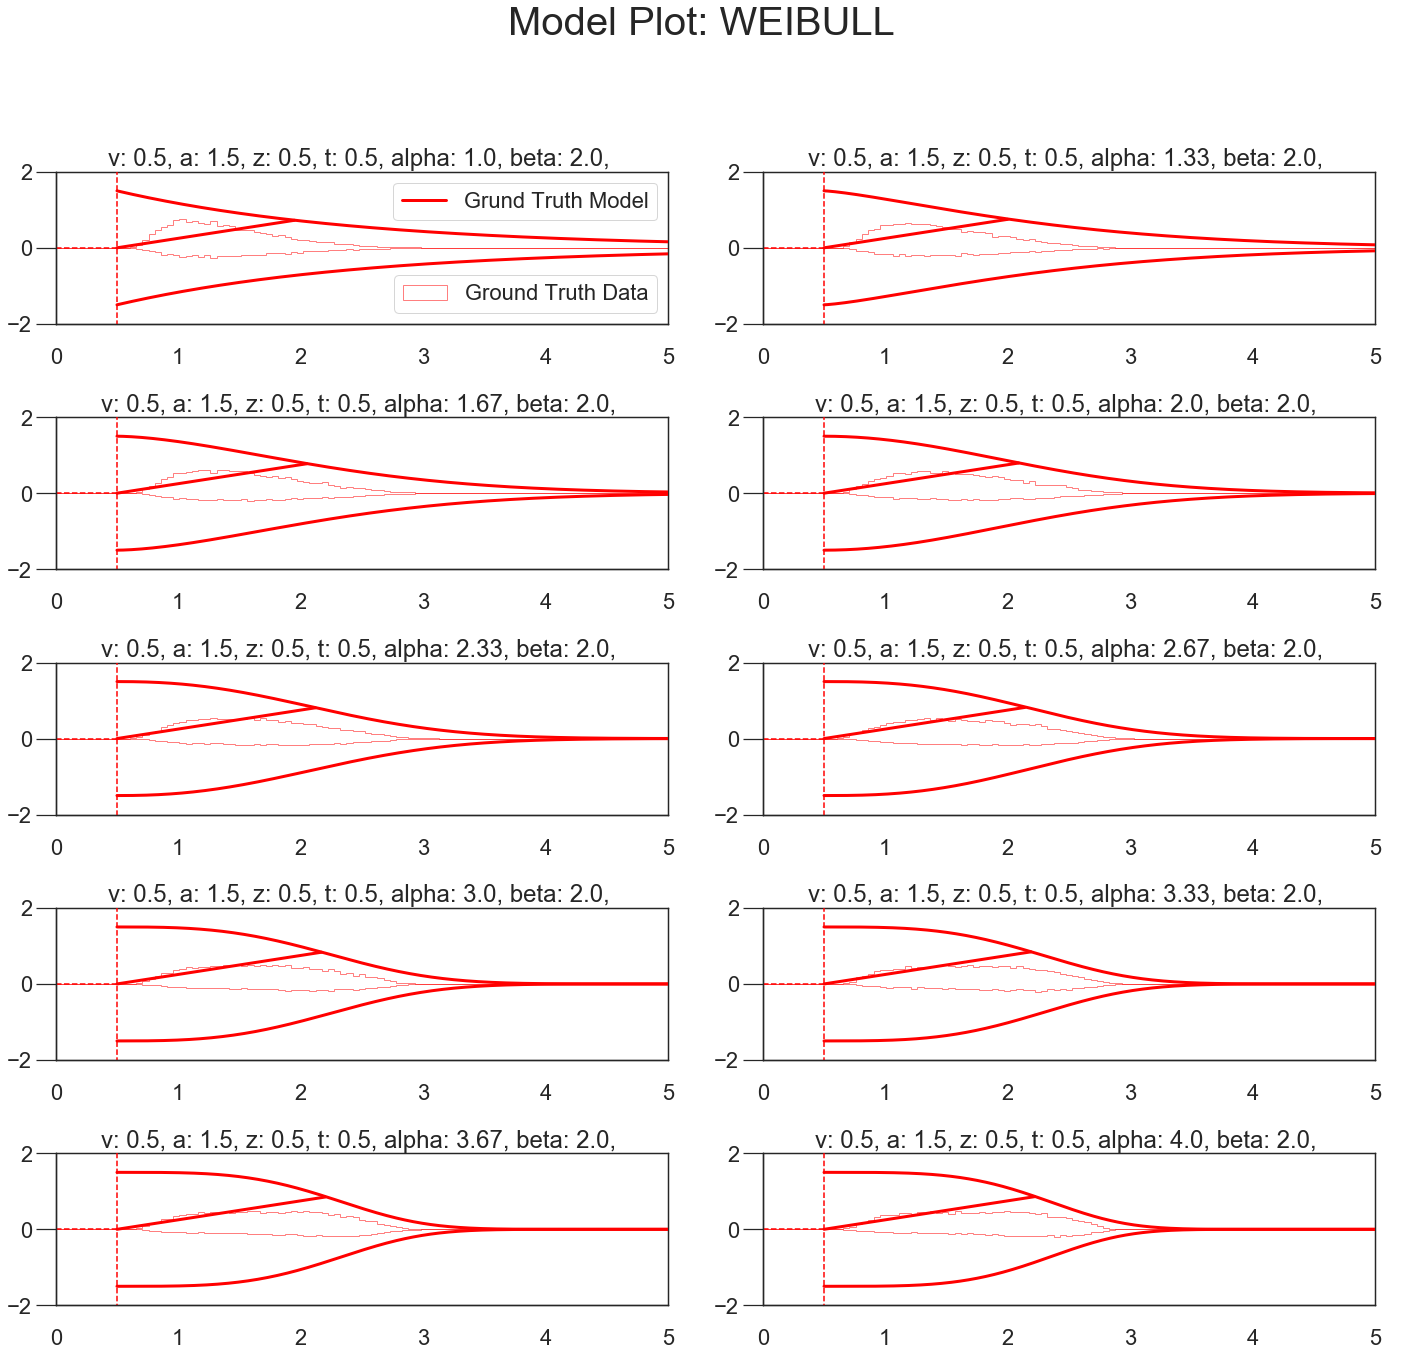

In [25]:
# Plotting the data
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 10,
                                     param_dict = {'a': [1.5],
                                                   'v': [0.5],
                                                   'z': [0.5],
                                                   'alpha': [i for i in np.linspace(1, 4, 10)],
                                                   'beta': [2],
                                                   't': [0.5]})

#Model Plots (Only data)
model_plot(ground_truths = weibull_params.values,
           cols = 2, 
           model_gt = 'weibull_cdf',
           n_plots = 10,
           max_t = 5,
           show_model = True)

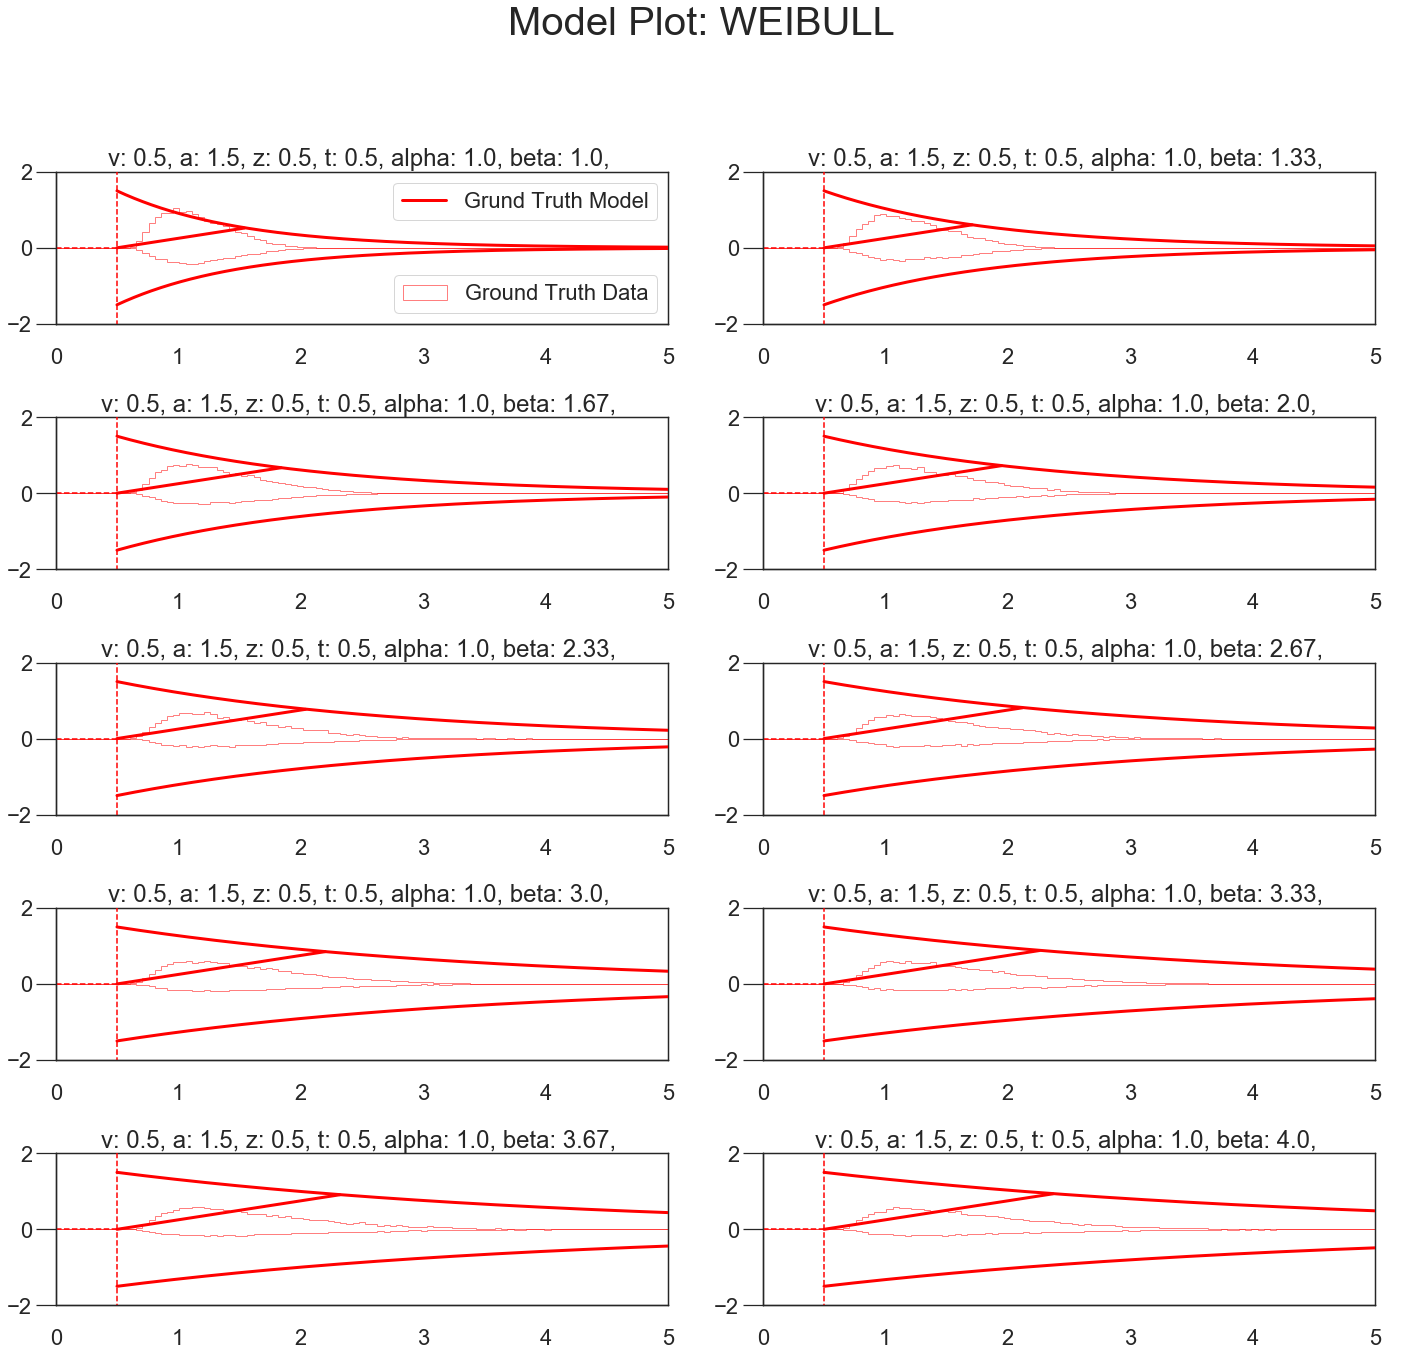

In [35]:
# Plotting the data
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.5],
                                                 'v': [0.5],
                                                 'z': [0.5],
                                                 'alpha': [1],
                                                 'beta': [i for i in np.linspace(1, 4, 10)],
                                                 't': [0.5]})

#Model Plots (Only data)
model_plot(ground_truths = weibull_params.values,
           cols = 2, 
           model_gt = 'weibull_cdf',
           n_plots = 10,
           max_t = 5,
           show_model = True)

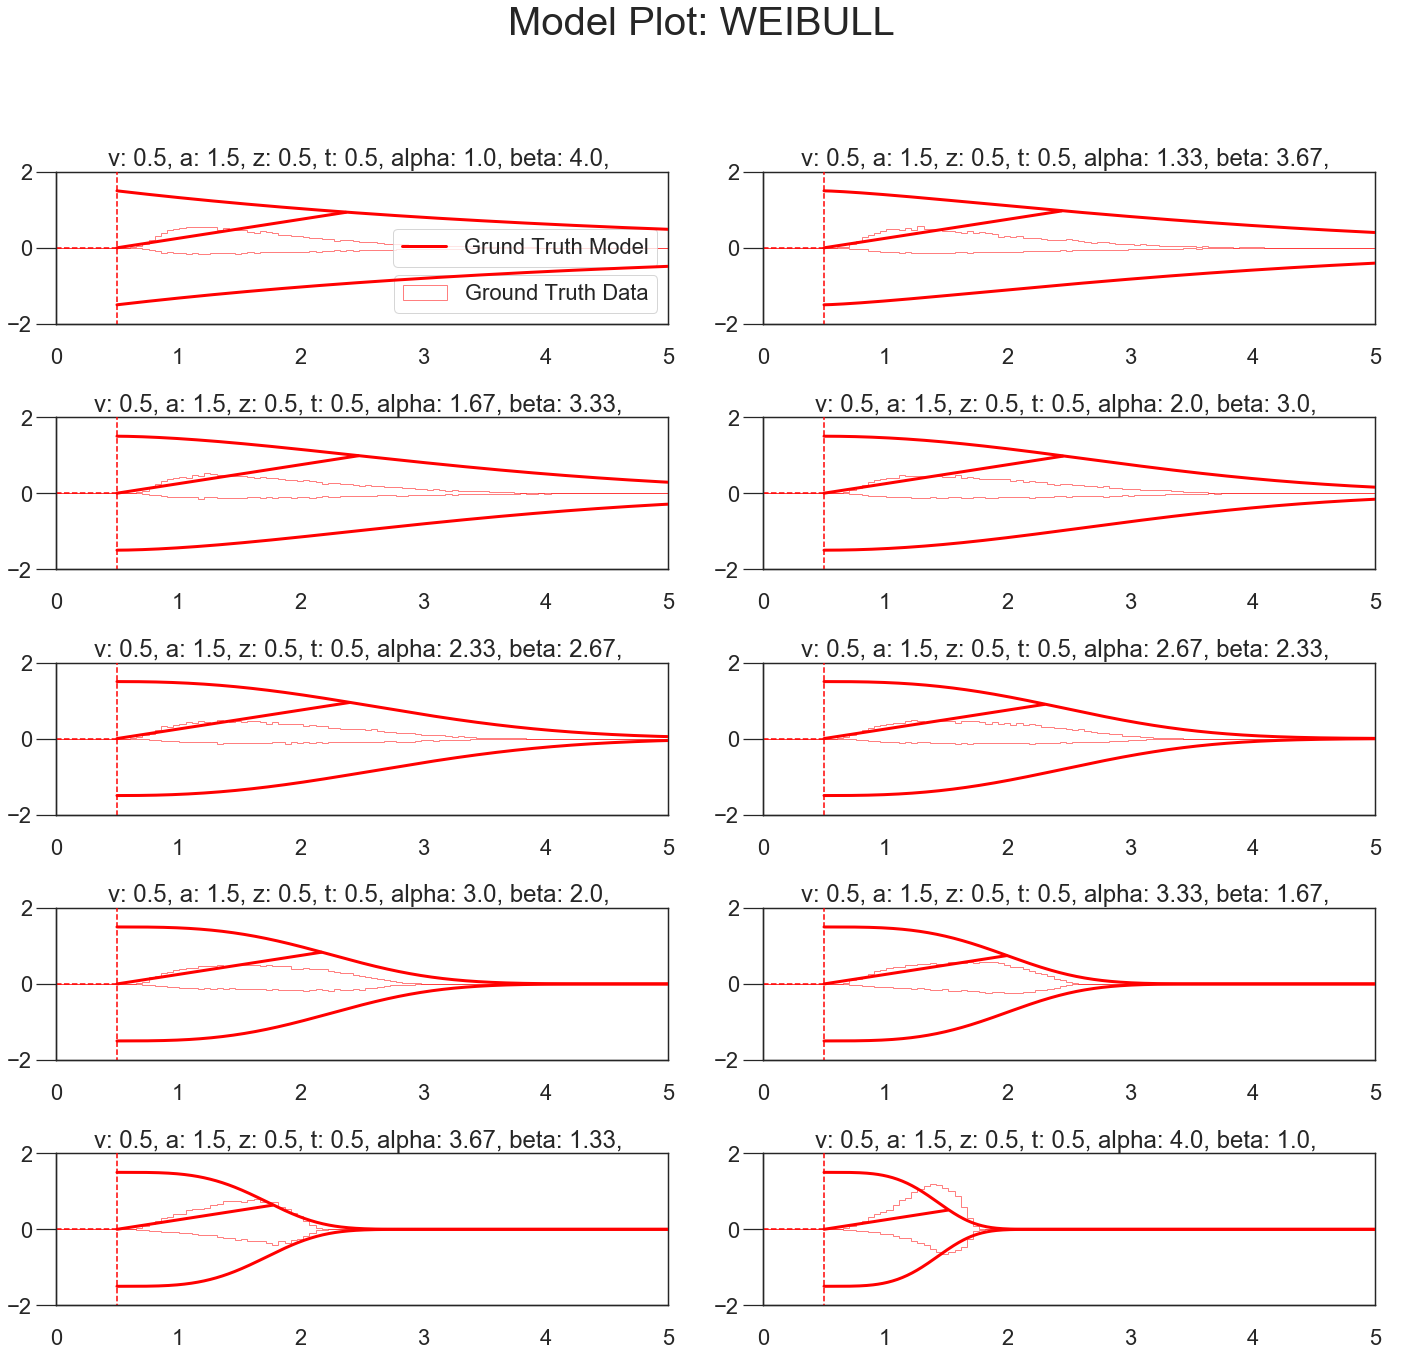

In [36]:
# Plotting the data
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.5],
                                                 'v': [0.5],
                                                 'z': [0.5],
                                                 'alpha': [i for i in np.linspace(1, 4, 10)],
                                                 'beta': [i for i in np.linspace(4, 1, 10)],
                                                 't': [0.5]})

#Model Plots (Only data)
model_plot(ground_truths = weibull_params.values,
           cols = 2, 
           model_gt = 'weibull_cdf',
           n_plots = 10,
           max_t = 5,
           show_model = True)

# Section 2: Estimation for Single Subjects (collapsed data)

### WEIBULL MODEL

Now, we try to fit these models to data! Let's start with an simple dataset. In other words, we have one single participant who gave us 1000 datapoints.

In [75]:
# WEIBULL MODEL
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                   n_parameter_sets = 1)

simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 1000)

hddm_data_weibull_single_subject = hddm_preprocess(simulations)

In [76]:
# Look at the ground truth params
weibull_params

v         a         z         t     alpha      beta
0  0.423204  1.091808  0.352043  0.551397  3.124345  1.909181

In [77]:
# A look at the dataset
hddm_data_weibull_single_subject.head()

rt  response  nn_response  subj_idx
0  1.391389       0.0           -1         0
1  0.895396       0.0           -1         0
2  1.240391       1.0            1         0
3  0.915395       0.0           -1         0
4  1.764397       1.0            1         0

Ideally we would want to simulate a dataset from scratch and fitting it. The code to do so, is commented out above. However, due to time constraints, we will load in a dataset, its ground truth parameter and its trace. Note that the ``pickle`` is a tuple of:

0. The trace
1. Ground truth parameter
2. Dataset

Let's look at the ground truth parameter

### hddm.HDDMnn_weibull(data, informative = False, free = False, k = True, include = ['z'], is_group_model = False)

Parameters:

- **data**: a ``pandas`` object - the dataset
- **informative**: bool, **True** if you want the model to talk to you while it's running
- **free**: bool, **False** if we are using parameters that have been trained on the network.
- **k**: bool, **True** to include $alpha$ in the fit
- **include**: a dictionary, whether or not to also fit $z$
- **is_group_model**: bool, **False** if fitting collapsed data, **True** if fitting hierarchical participant data.

In [78]:
# Defining a hddm model
hddm_model_weibull_single_subject = hddm.HDDMnn_weibull(hddm_data_weibull_single_subject, 
                                                informative = False, 
                                                free = False, 
                                                k = True,
                                                include = ['z'],
                                                is_group_model = False)

In [79]:
nmcmc = 300
hddm_model_weibull_single_subject.sample(nmcmc, 
                                         burn = 100)

 [-----------------100%-----------------] 300 of 300 complete in 16.2 sec

Now that we have run a fit, we look to find ways to visualised the recovered parameters to make sure the model is performing accurately. A caterpillar plot is a good way to visualise both the precision and accuracy of the task. Here, the red dot represents the ground truth value. The black bars are where the trace lies, with the black box indicating < > percentile. (You have seen this in one of your previous **hddm tutorials** (?))

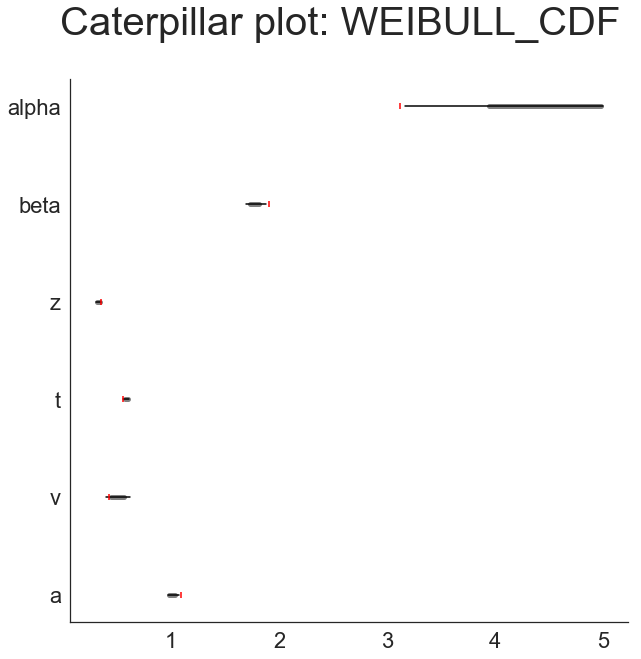

In [80]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(),
                 ground_truths = weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

### Posterior Predictive
Another way to examine whether or not our recovery was satisfactory is to perform posterior predictive checks. Essentially, we are looking to simulate datasets from the trace and check whether it aligns with the ground truth participant data. This answers the question of whether or not these parameters that you recovered can actually reproduce the data. Note that the parameter ``n_post_params`` controls the number of samples drawn from the trace. Here we draw randomly 200 (out of 1200).

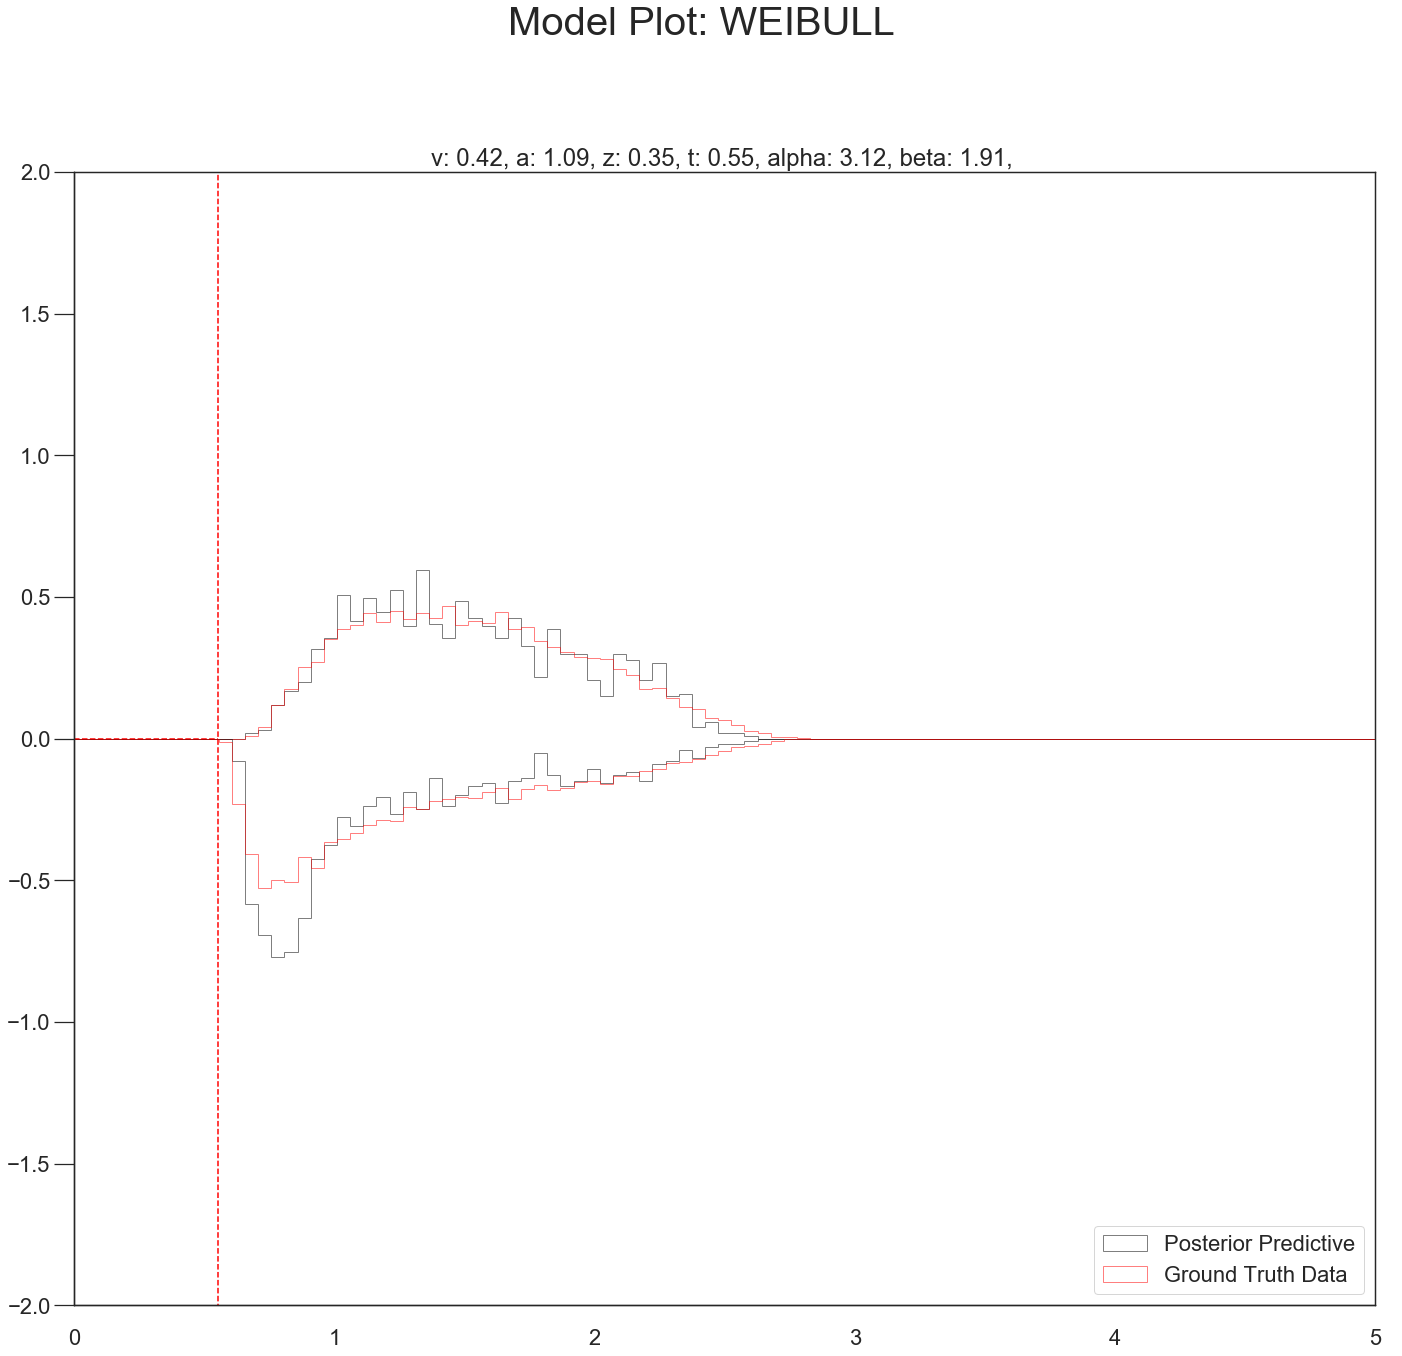

In [82]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
model_plot(ground_truths = weibull_params.values[0],
           posterior_samples =  hddm_model_weibull_single_subject.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = False,
           input_hddm_trace = True,
           datatype = 'single_subject')

We can also overlay the traces on the previous plot to see whether or not the trace is making sense. Every black line/curve is one trace's parameter. The wider a bundle the curves make, the more variability there is in the trace. The more they form one solid dark line, the less variability.

passed through legend part
0
0


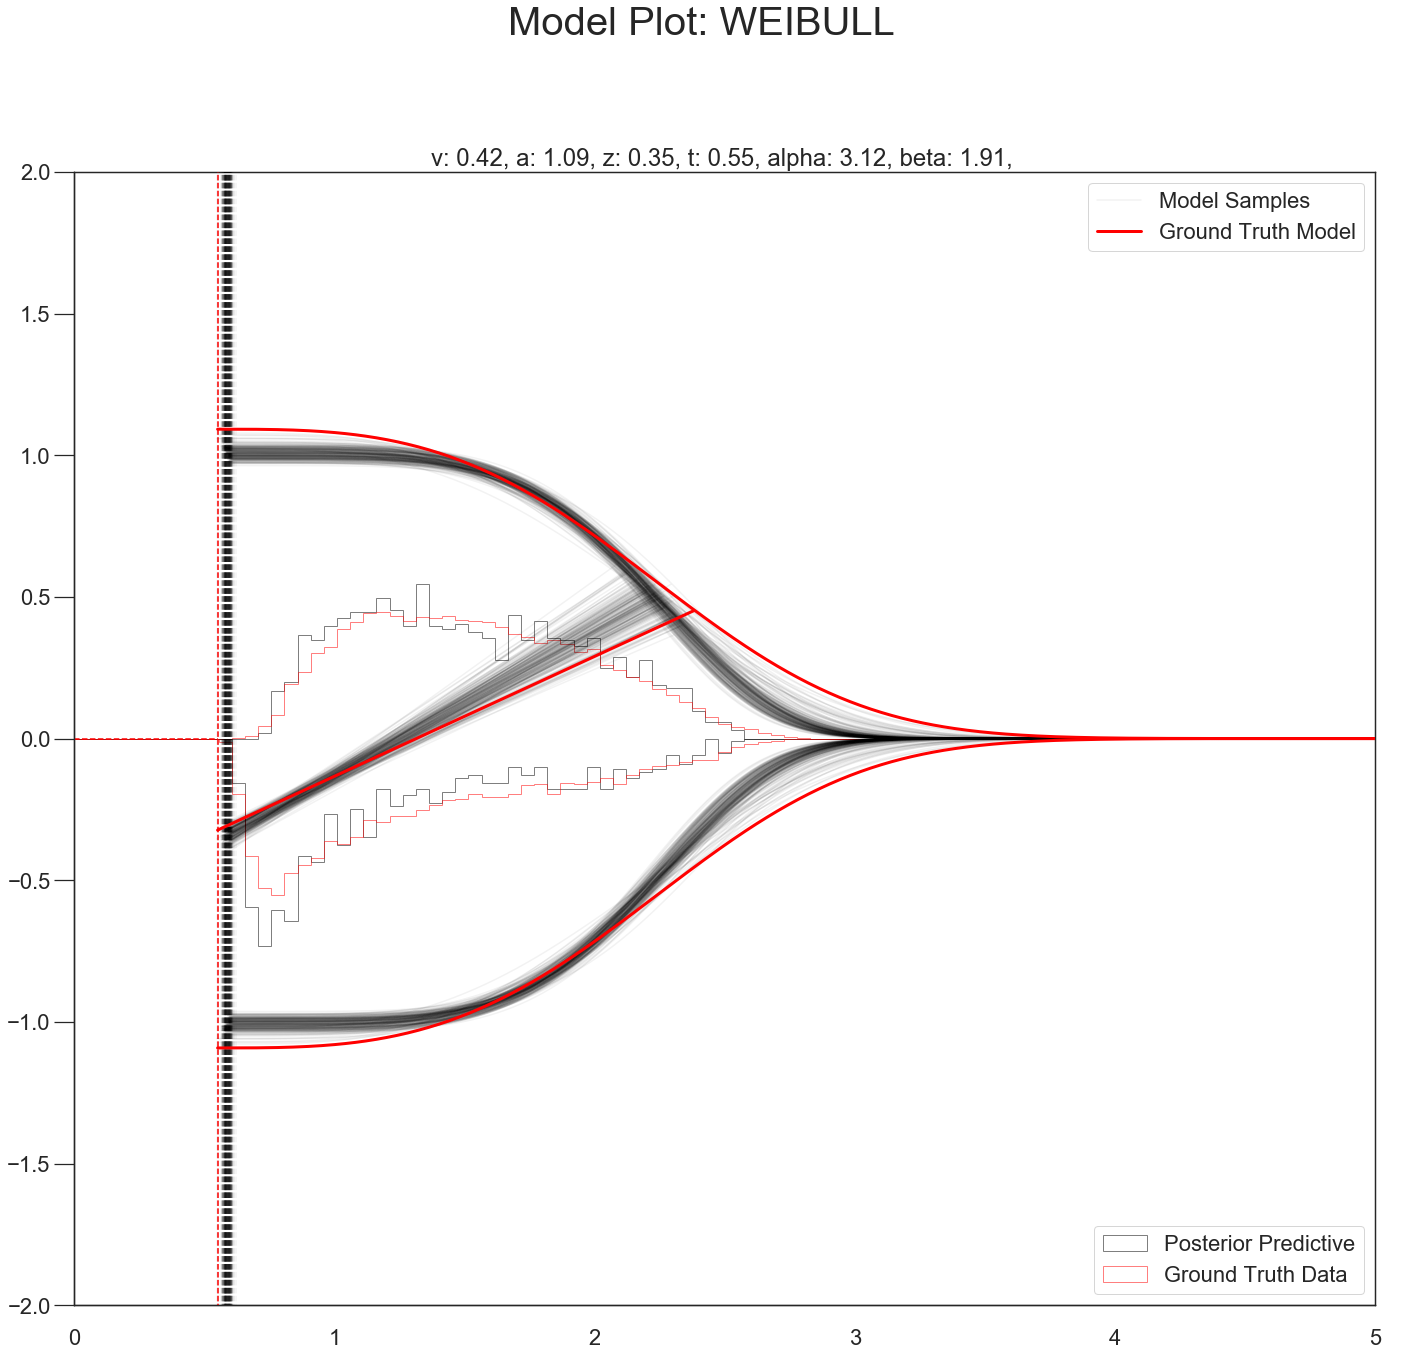

In [84]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths = weibull_params.values[0],
           posterior_samples =  hddm_model_weibull_single_subject.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

#### A small note on convergence

Note that the MCMC algorithm requires the chain to converge.There are many heuristics that help you identifying problems with convergence, such as the trace plot, auto correltion plot, and marginal posterior histogram. In the trace plots, there might be a problem if you see large jumps. In the autocorrelation plot, there might be a problem if it does not drop rapidly.

In [ ]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddm_model_weibull_single_subject.plot_posteriors(['a', 't', 'v', 'z', 'alpha', 'beta'])

To avoid longer waiting times during the tutorial, instead of running the sampler for every model we show, we will load **pre-computed posteriors** some or all of the times below. Code for loading such datasets is listed below.

In [23]:
# Load in the data
load_in = pickle.load(open('data_storage/single_subject_weibull_n_1000.pickle', 'rb'))

weibull_trace_s = load_in[0]
weibull_params_s = load_in[1]
weibull_dataset_s = load_in[2]

Now we look at the trace for said fit

In [88]:
# A look at the trace object
weibull_trace_s.head()

a         v         t   z_trans      beta     alpha
0  1.387207 -0.416730  0.422329 -0.371980  2.176990  2.385490
1  1.361826 -0.422416  0.436861 -0.404456  2.187864  2.375570
2  1.346161 -0.446058  0.446897 -0.423029  2.223950  2.379973
3  1.347924 -0.465763  0.452156 -0.433510  2.212851  2.424667
4  1.339708 -0.360379  0.470504 -0.443158  2.184911  2.498354

In [89]:
weibull_params_s

v         a         z         t     alpha      beta
0 -0.41381  1.622475  0.414375  0.350403  1.510861  2.292644

In [91]:
weibull_dataset_s.head()

rt  response  nn_response  subj_idx
0  1.466399       0.0           -1         0
1  1.427398       1.0            1         0
2  2.711415       0.0           -1         0
3  1.287395       0.0           -1         0
4  1.412397       0.0           -1         0

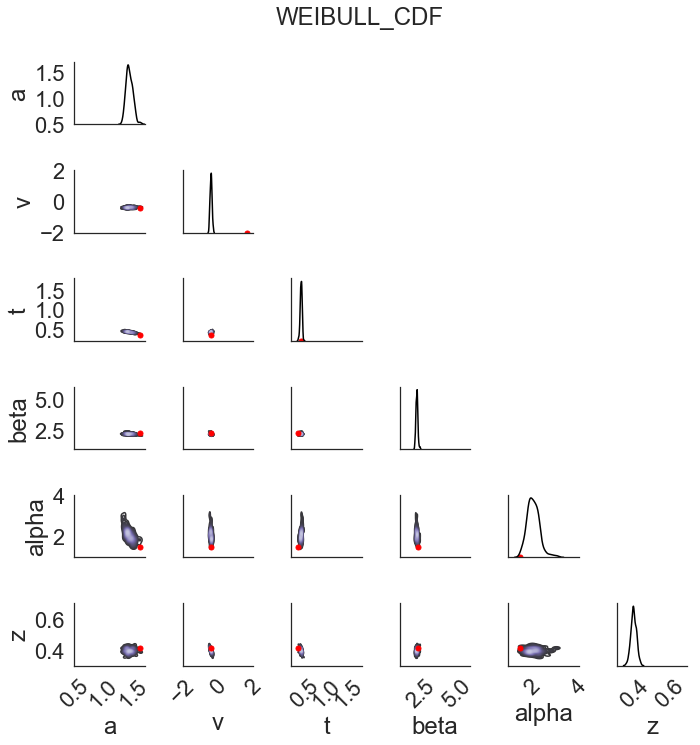

In [24]:
# Pairwise posterior plot
posterior_pair_plot(posterior_samples = weibull_trace_s,
                    height = 10,
                    aspect = 1,
                    n_subsample = 200,
                    ground_truths = weibull_params_s.values[0],
                    model = 'weibull_cdf')

### ANGLE MODEL

We can do the same thing for the **Angle model**. (Precomputed here)

In [96]:
load_in = pickle.load(open("single_subject_angle_n_1000.pickle", "rb"))
angle_trace_s = load_in[0]
angle_params_s = load_in[1]
angle_dataset_s = load_in[2]

In [97]:
angle_params_s

v         a         z         t     theta
0 -0.973407  0.872892  0.350307  1.499637  0.573077

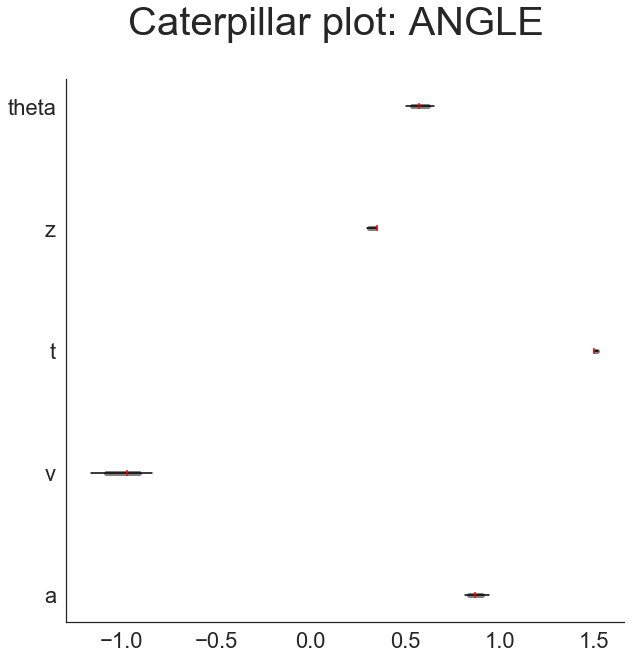

In [99]:
# Caterpillar Plot: 
caterpillar_plot(posterior_samples = angle_trace_s,
                 ground_truths = angle_params_s.values[0],
                 model = 'angle',
                 datatype = 'single_subject',
                 drop_sd = True)

passed through legend part
0
0


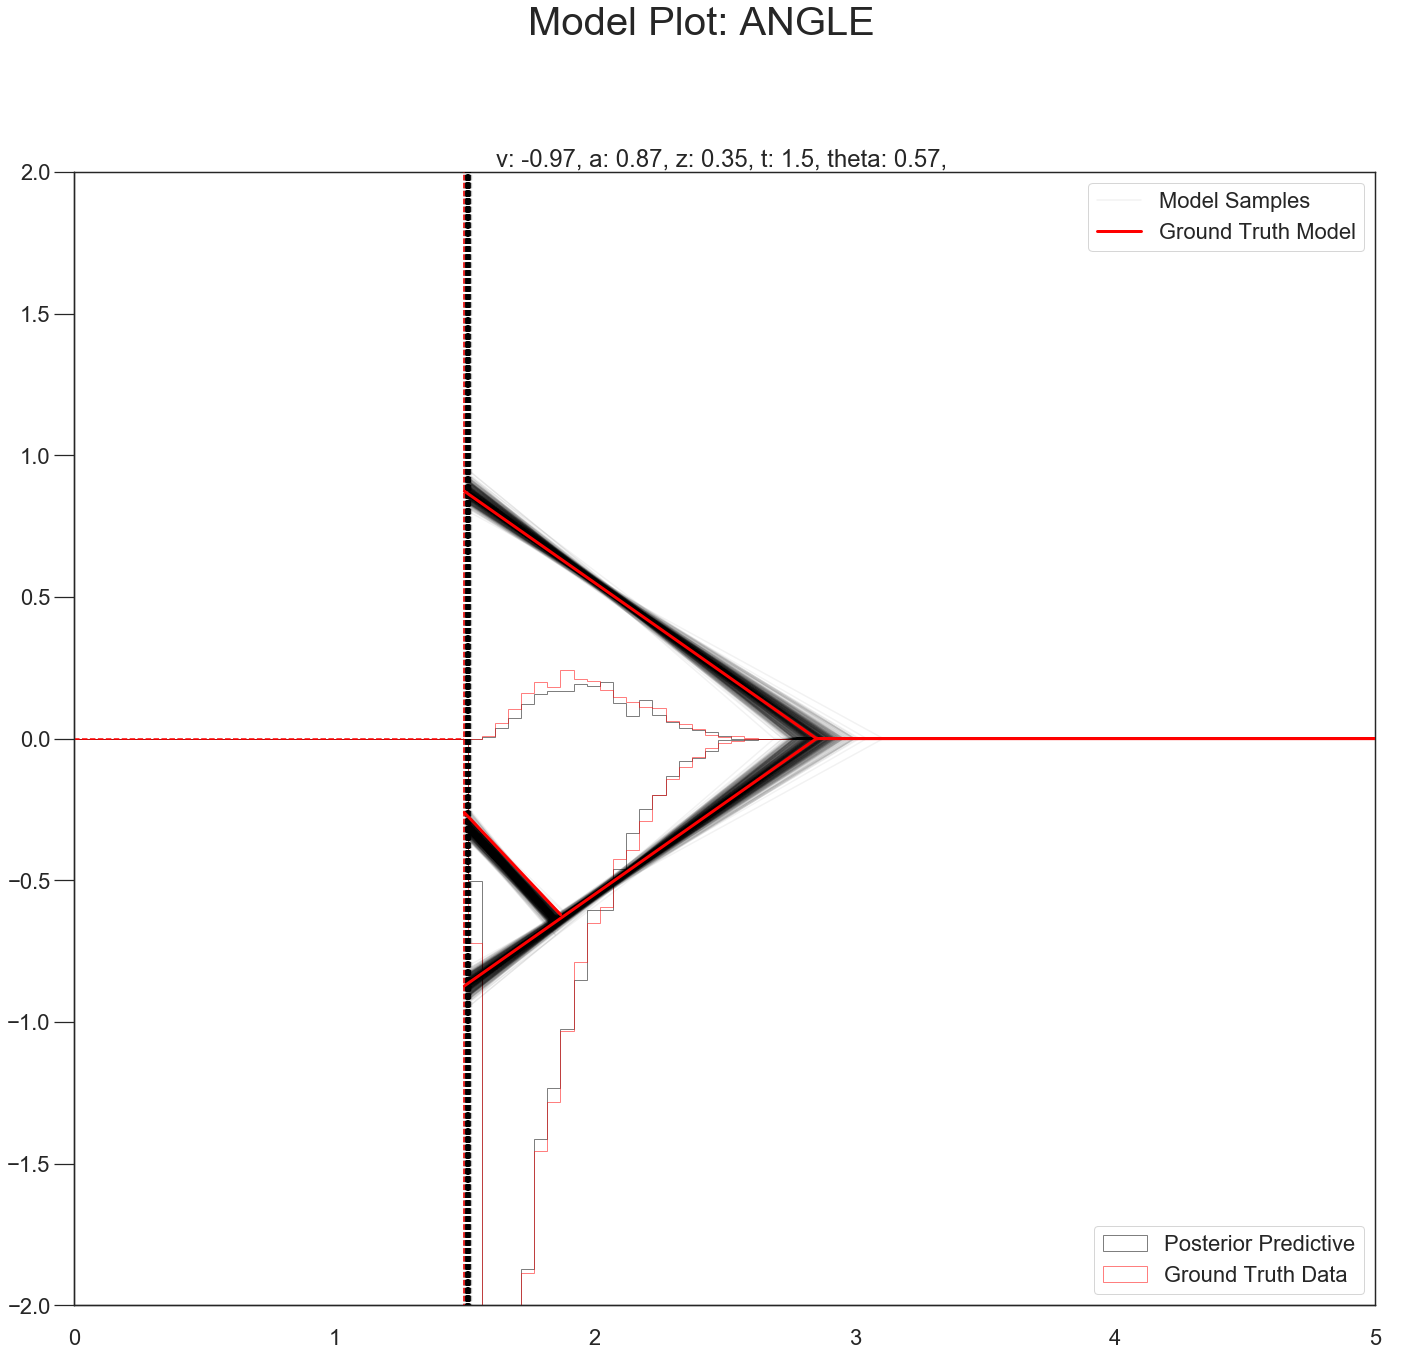

In [101]:
# Posterior Predictive with model line
model_plot(ground_truths = angle_params_s.values[0],
           posterior_samples = angle_trace_s,
           model_gt = 'angle',
           model_fitted = 'angle',
           n_post_params = 500,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

In [57]:
hddm_model_single_subject = hddm.HDDMnn_angle(a_process, 
                                                informative = False, 
                                                free = False, 
                                                include = ['z'],
                                                is_group_model = False)

In [58]:
hddm_model_single_subject.sample(1500, burn = 200, dbname = 'traces.db', db = 'pickle')

 [-----------------100%-----------------] 1501 of 1500 complete in 937.6 sec

In [59]:
pickle.dump((hddm_model_single_subject.get_traces(),
             angle_params,
             a_process), open("single_subject_angle_n_1000.pickle", "wb") )

# Section 3: Fitting hierarchical model

The 'h' in `hddm` stands for hierarchical, so let's do it! If we have data from multiple participants and we assume that the parameters of single participants are drawn from respective **group** or **global** distributions, we can model this explicitly in `hddm` by specifying `is_group_model = True`.

Implicitly we are fitting a model of the following kind,

$$p(\{\theta_j\}, \{\theta_g\} | \mathbf{x}) \propto \left[ \prod_j^{J} \left[ \prod_i^{N_j} p(x_i^j | \theta_j) \right] p(\theta_j | \theta_g) \right] p( \theta_g | \theta_h )$$

where (let's say for the **weibull model**) $\theta_j = \{v_j, a_j, z_j, t_j, \alpha_j, \beta_j \}$, are the model parameters for **subject j**. $\theta_g = \{v_g^{\mu}, a_g^{\mu}, z_g^{\mu}, t_g^{\mu}, \alpha_g^{\mu}, \beta_g^{\mu}, v_g^{\sigma}, a_g^{\sigma}, z_g^{\sigma}, t_g^{\sigma}, \alpha_g^{\sigma}, \beta_g^{\sigma} \}$ (scary, but for completeness), are the **mean** and **variance** parameters for our group level normal distributions, and {\theta_h} are fixed hyperparameters.
$x_i^j = \{rt_i^j, c_i^j \}$, are the **choice and reaction time**  of **subject j** during **trial i**.

In words, the right hand side of the equation tells us that we have a **global parameter distribution** with certain **means** and **variances** for each parameter (we want to figure these means and variances out), from which the **subject level parameters** are drawn and finally **subject level datapoints** follow the likelihood distribution of our **ddm / angle / weibull / you name it** mdoels.

### ANGLE MODEL

### Loading a dataset from a hierarchical generating process

Below the code you can run to generate a fit online. We will use a preloaded fit here.

In [102]:
# You can use this code to load one of 10 hierarchical datasets included in the tutorial files
# hddm_data_hierarchical_angle = hddm_preprocess_hierarchical(model = 'angle', 
#                                                             datasetid = 0)

In [106]:
# hddm_data_hierarchical_angle[2]

In [104]:
# hddm_hierarchical_model_angle = hddm.HDDMnn_angle(hddm_data_hierarchical_angle[0], 
#                                                   free = False,
#                                                   informative = False,
#                                                   include = 'z',
#                                                   is_group_model = True)

In [105]:
# # Sampling:
# nmcmc = 1500
# hddm_hierarchical_model_angle.sample(nmcmc,
#                                burn = 200, 
#                                dbname = 'traces_hierarchical_angle_tutorial.db', 
#                                db = 'pickle')

 [-----------------74%--------          ] 1120 of 1500 complete in 1128.0 secHalting at iteration  1119  of  1500


In [3]:
hddm_data_hierarchical_angle = hddm_preprocess_hierarchical(model = 'angle', 
                                                            datasetid = 0)
load_in = pickle.load(open("data_storage/hierarchy_n_1000.pickle", "rb") )
angle_trace_h = load_in[0]
#angle_params_h = load_in[1]
#angle_dataset_h = load_in[2]

NameError: name 'hddm_preprocess_hierarchical' is not defined

In [110]:
angle_trace_h.head()

a     a_std  a_subj.0.0  a_subj.1.0  a_subj.2.0  a_subj.3.0  \
0  1.716604  0.037769    1.750320    1.652669    1.684997    1.732030   
1  1.717259  0.041693    1.729160    1.651659    1.680795    1.732404   
2  1.693787  0.023922    1.732870    1.657853    1.702597    1.703863   
3  1.712336  0.022922    1.740379    1.663974    1.707317    1.711137   
4  1.684828  0.041958    1.714929    1.697442    1.718806    1.724877   

   a_subj.4.0         v     v_std  v_subj.0.0  ...  z_subj_trans.2.0  \
0    1.701668 -1.302093  0.006144   -1.299570  ...          0.455130   
1    1.700607 -1.300873  0.011651   -1.311807  ...          0.438999   
2    1.700516 -1.301621  0.008014   -1.308900  ...          0.445583   
3    1.675497 -1.296244  0.010500   -1.290087  ...          0.465841   
4    1.681763 -1.317468  0.035479   -1.307189  ...          0.461849   

   z_subj_trans.3.0  z_subj_trans.4.0     theta  theta_std  theta_subj.0.0  \
0          0.449286          0.425479  0.971732   0.028788        0.977294   
1          0.437626          0.452643  0.965120   0.029074        0.975520   
2          0.449743          0.443077  1.000506   0.032297        0.975566   
3          0.454171          0.449755  0.971022   0.061220        0.968719   
4          0.449171          0.445113  0.972652   0.022113        0.968455   

   theta_subj.1.0  theta_subj.2.0  theta_subj.3.0  theta_subj.4.0  
0        0.924405        0.950567        1.006755        0.980968  
1        0.918255        0.954315        1.008838        0.967638  
2        0.919025        0.960235        1.007279        0.965765  
3        0.937387        0.962073        0.984512        0.958590  
4        0.930912        0.970234        0.992121        0.961124  

[5 rows x 35 columns]

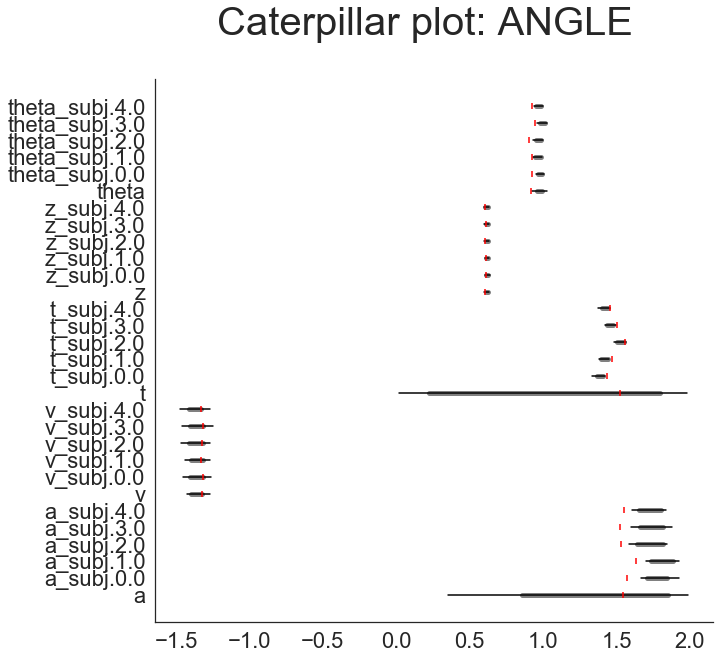

In [111]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = angle_trace_h,
                 ground_truths = hddm_data_hierarchical_angle,
                 model = 'angle',
                 datatype = 'hierarchical',
                 drop_sd = True)

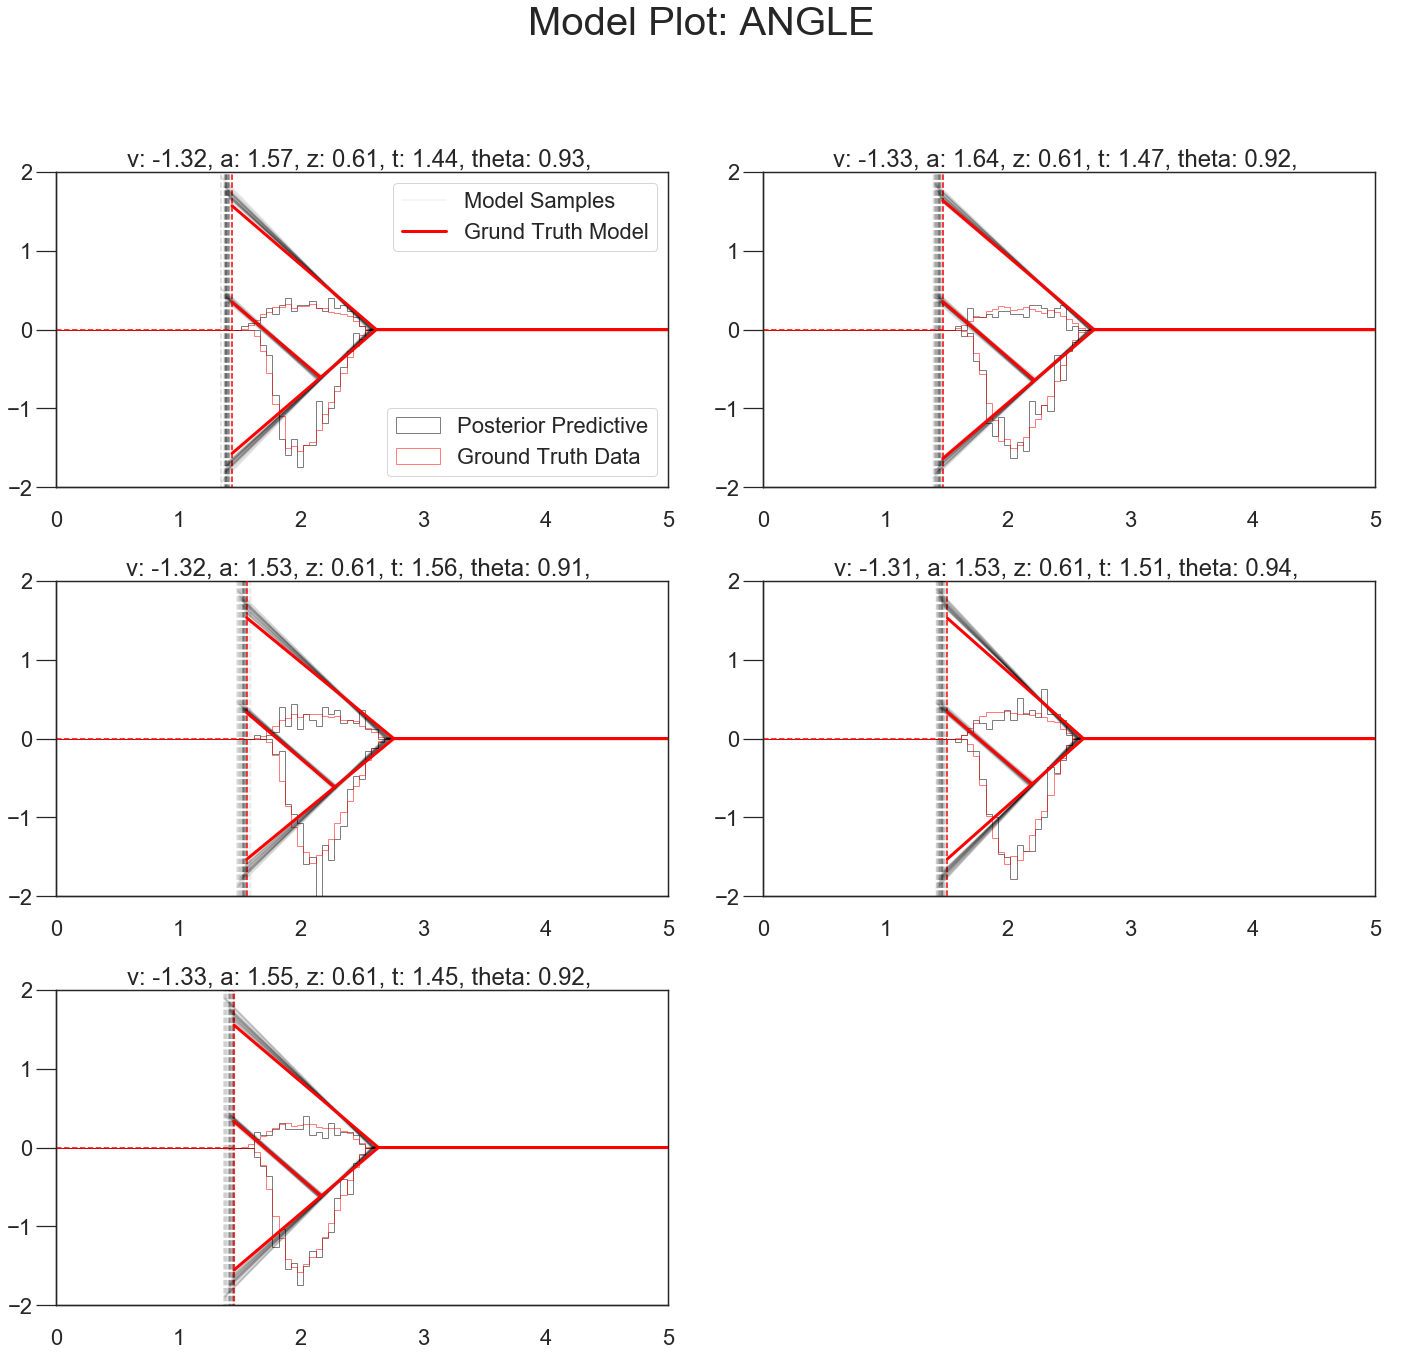

In [113]:
# Posterior Predictive
model_plot(ground_truths = hddm_data_hierarchical_angle[1].values,
           posterior_samples = hddm_hierarchical_model_angle.get_traces(),
           input_hddm_trace = True,
           n_post_params = 200,
           cols = 2, 
           model_gt = 'angle',
           model_fitted = 'angle',
           datatype = 'hierarchical',
           n_plots = 5,
           max_t = 5,
           show_model = True)

### WEIBULL

In [7]:
# WEIBULL
hddm_data_hierarchical_weibull_cdf = hddm_preprocess_hierarchical(model = 'weibull_cdf', 
                                                                  datasetid = 1)


# Loading in data
load_in = pickle.load(open('data_storage/weibull_hierarchical_n_1000.pickle', 'rb'))
weibull_trace_h = load_in[0]

In [8]:
hddm_data_hierarchical_weibull_cdf[0].head()

response        rt  subj_idx  nn_response
0       1.0  2.125856       0.0          1.0
1       1.0  1.877859       0.0          1.0
2       0.0  2.042857       0.0         -1.0
3       0.0  2.124856       0.0         -1.0
4       1.0  2.590876       0.0          1.0

In [11]:
# hddm_hierarchical_model_weibull_cdf = hddm.HDDMnn_weibull(hddm_data_hierarchical_weibull_cdf[0], 
#                                                          free = False,  
#                                                          informative = False, 
#                                                          include = 'z',
#                                                          k = True,
#                                                          is_group_model = True)

In [12]:
# nmcmc = 1500
# hddm_hierarchical_model_weibull_cdf.sample(nmcmc, burn = 500)

 [-----------------100%-----------------] 1501 of 1500 complete in 1026.3 sec

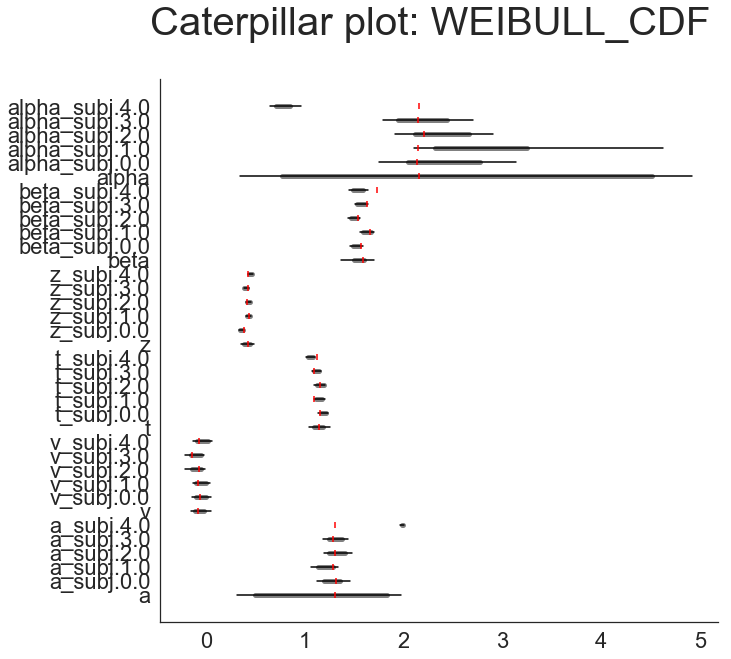

In [9]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = weibull_trace_h,
                 ground_truths = hddm_data_hierarchical_weibull_cdf,
                 model = 'weibull_cdf',
                 datatype = 'hierarchical',
                 drop_sd = True)

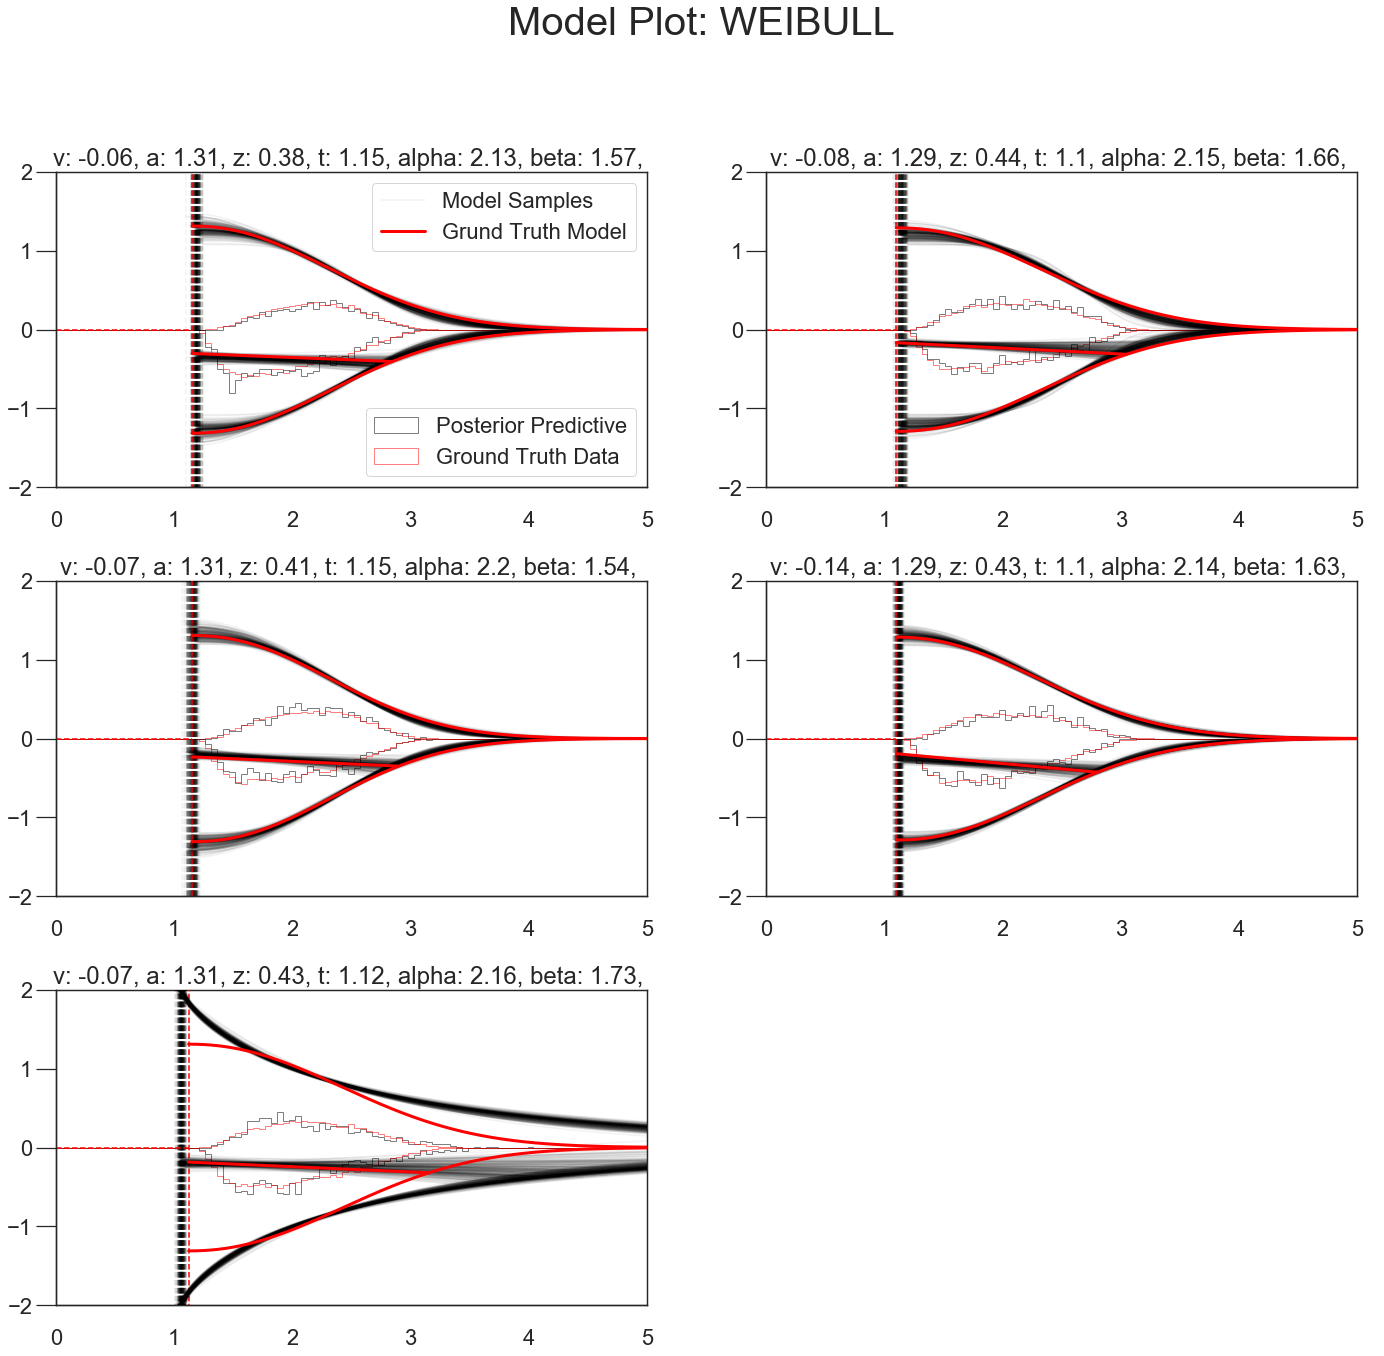

In [11]:
# Posterior Predictive
model_plot(ground_truths = hddm_data_hierarchical_weibull_cdf[1].values,
           posterior_samples = weibull_trace_h,
           input_hddm_trace = True,
           n_post_params = 200,
           cols = 2, 
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           datatype = 'hierarchical',
           n_plots = 5,
           max_t = 5,
           show_model = True)

# SECTION 4: PARAMETER VARIES BY CONDITION

An important aspect of these posterior analysis, is the consideration of experiment design.
We may have an experiment in which subject are exposed to a variety of conditions, 
such as for example different degrees of difficulty of the same task

It is often reasonable to assume that all but the conceptually relevant parameters are common across conditions.

As a by-product, such experiment designs can help us with the recovery of the constant parameters, by probing those static aspects of the model across varying kinds of datasets (driven by targeted manipulation of variable aspects of the model).

Implicitly we fit the following kind of model,

$$p( \{\theta_c \}, \theta | \mathbf{x} ) \propto  \left[ \prod_c^C  \left[ \prod_i^{N_i} p( x_i^c | \theta_c, \theta ) \right] p(\theta_c)  \right] p(\theta)$$


Where $\theta_c$ is the condition dependent part of the parameter space, and $\theta$ forms the portion of parameters which remain constant across condtions. 

To give a more concrete example involving the **weibull model** (executed below), consider a dataset for a single participant, who went through four conditions of an experiment. Think of the conditions as manipulating the payoff structure of the experiment to incentivize / disincentivize accuracy in favor of speed. We operationalize this by treating the $a$ parameter, the initial boundary separation, as affected by the manipulation, while the rest of the parameters are constant across all experiment conditions.

The resulting model would be of the form, 

$$ p( {a_c}, v, z, t, \alpha, \beta | x ) \propto \left[ \prod_c^C  \left[ \prod_i^{N_c} p( x_i^c | a_c, v, z, t, \alpha, \beta)  \right] p(a_c) \right]  p(v, z, t, \alpha, \beta)$$ 

### WEIBULL

Again we comment out the sampling code, to save some time. 
You can uncomment and run this code if you like.

In [12]:
# Generating some data
# We generate data such that only one parameter varies by condition (in this case 'a' --> the initial boundary separation)
# hddm_data_condition, gt_condition, gt_mat_condition = simulator_condition_effects(n_conditions = 4, 
#                                                                                   n_samples_by_condition = 1000,
#                                                                                   condition_effect_on_param = ['a'], 
#                                                                                   model = 'weibull_cdf',
#                                                                                   )

In [13]:
# hddm_data_condition.head()

rt  response  nn_response  condition
0  2.436835       0.0           -1          0
1  1.409824       0.0           -1          0
2  2.963859       0.0           -1          0
3  2.346830       0.0           -1          0
4  1.346825       0.0           -1          0

In [156]:
# gt_condition

{'a(0)': 0.8605307694017392,
 'a(1)': 0.9798105987677244,
 'a(2)': 1.2973403356591042,
 'a(3)': 0.8919618353411207,
 'v': -0.3982804686782764,
 'z': 0.6419385027703207,
 't': 1.5702078579162195,
 'alpha': 2.5885596546844916,
 'beta': 5.477381879900294}

In [157]:
# hddm_model_condition = hddm.HDDMnn_weibull(hddm_data_condition, 
#                                            informative = False, 
#                                            free = False, 
#                                            k = True,
#                                            include = ['z'],
#                                            is_group_model = False, 
#                                            depends_on = {'a': 'condition'})

In [158]:
# ncmcm  = 1000
# hddm_model_condition.sample(nmcmc, burn = 200)

 [-----------------100%-----------------] 1500 of 1500 complete in 359.4 sec

In [15]:
# Again we use preloaded data
load_in = pickle.load(open('data_storage/condition_weibull_n_1000.pickle', 'rb'))

weibull_trace_c = load_in[0]
weibull_gt_c = load_in[1]
weibull_gt_mat_c = load_in[2]
weibull_data_c = load_in[3]

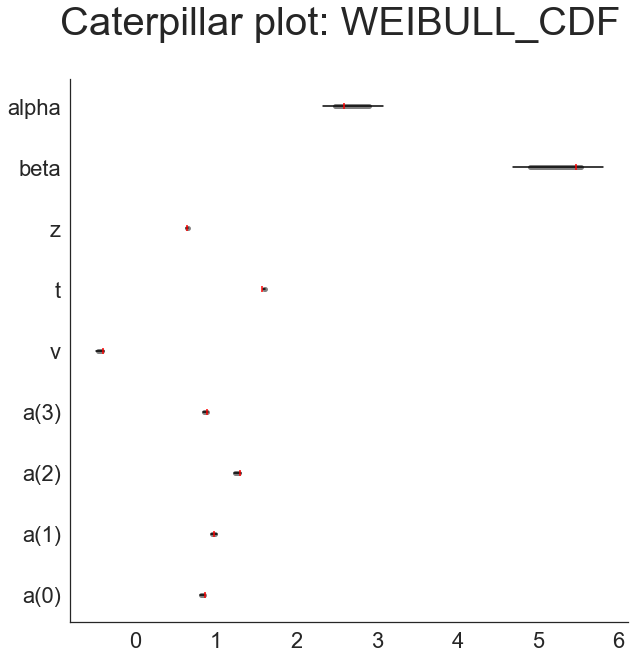

In [16]:
caterpillar_plot(posterior_samples = weibull_trace_c,
                 ground_truths = weibull_gt_c,
                 model = 'weibull_cdf',
                 datatype = 'condition',
                 drop_sd = True)

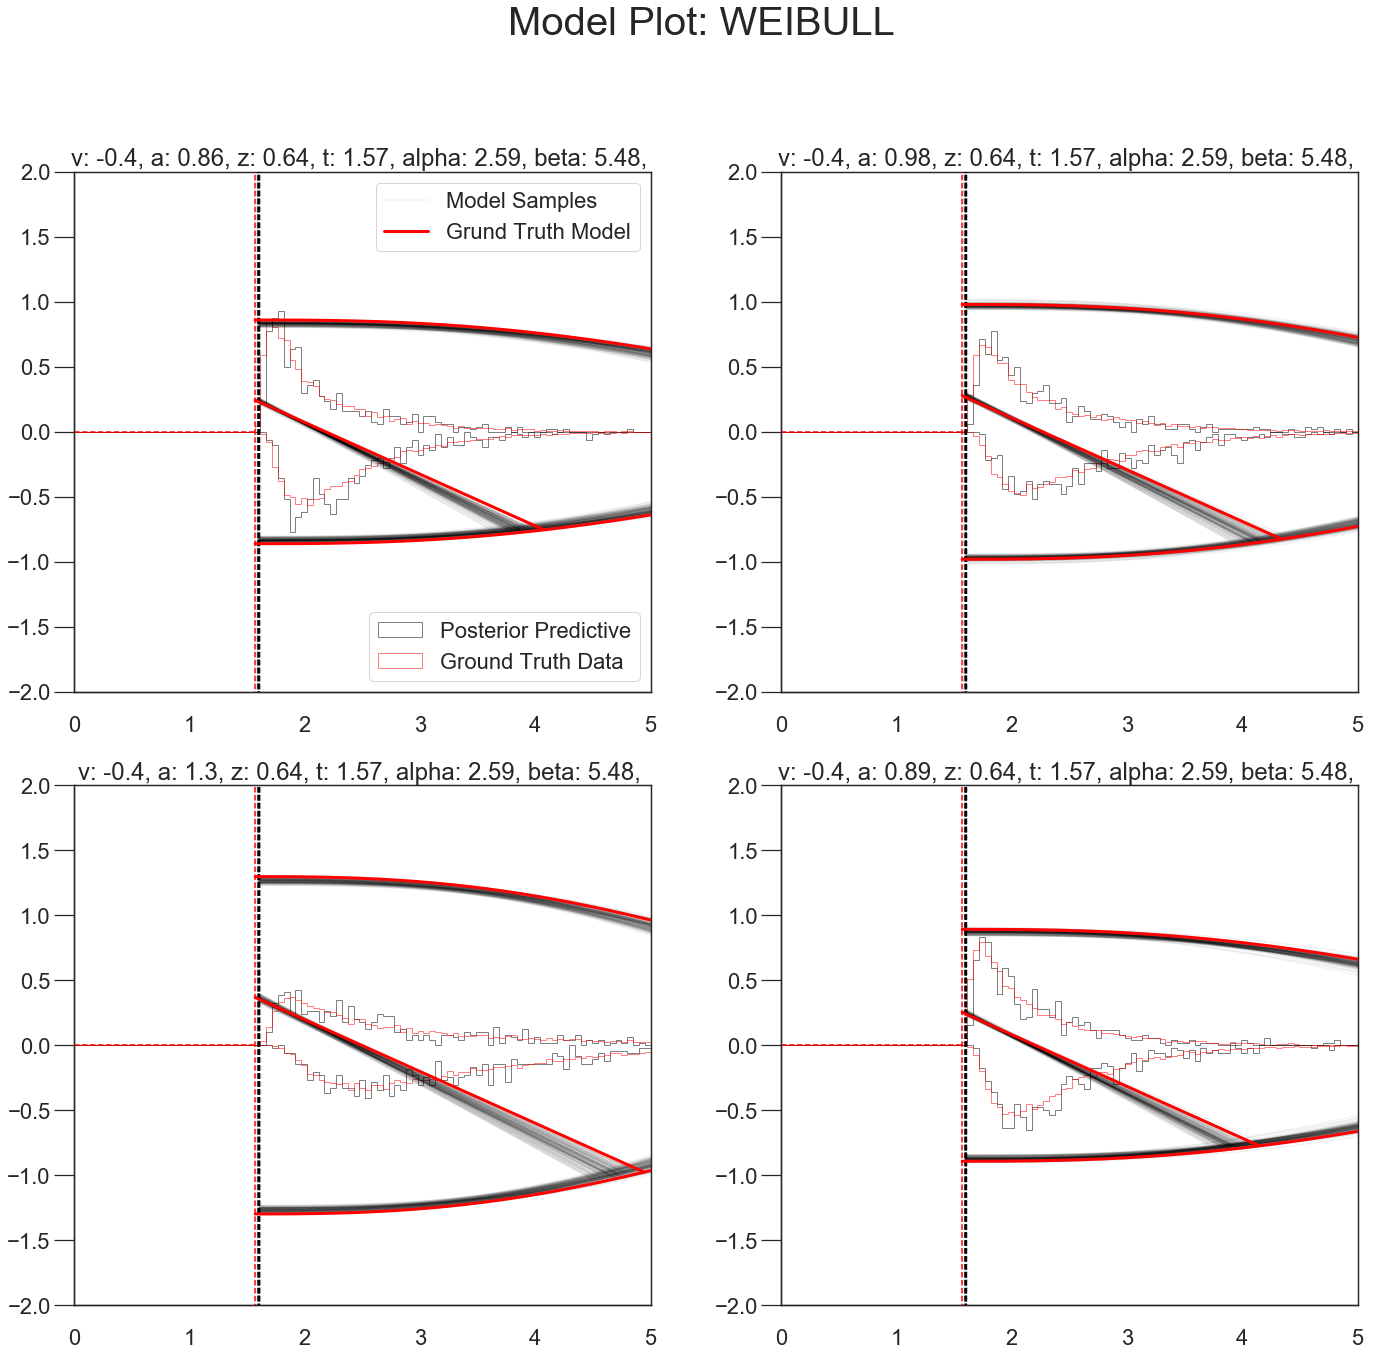

In [17]:
model_plot(posterior_samples = weibull_trace_c,
           ground_truths = weibull_gt_mat_c,
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           datatype = 'condition',
           input_hddm_trace = True,
           n_post_params = 100,
           n_plots = 1,
           cols = 2,
           show_model = True)

# SECTION 5: MODEL RECOVERY

Lastly we are going to look at model recovery, because it is tempting now that we have three kinds of models at our hands ( **ddm / angle / weibull **). 

For the little model recovery study we conduct here, we generate data from the **weibull** model and fit the data once each to the  **weibull**, **angle** and **ddm** models.

We inspect the fits visually and then use the *DIC* (Deviance information criterion, lower is better :)), to check if we can recover the **true** model. 

In [173]:
# Let's generate data from one of our three models
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 1)

simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 1000)

hddm_data_single_subject_weibull = hddm_preprocess(simulations)

In [174]:
# Now we fit for each model:
hddm_model_single_subject_weibull = hddm.HDDMnn_weibull(hddm_data_single_subject_weibull, 
                                                informative = False, 
                                                free = False, 
                                                k = True,
                                                include = ['z'],
                                                is_group_model = False)

hddm_model_single_subject_angle = hddm.HDDMnn_angle(hddm_data_single_subject_weibull, 
                                                    informative = False, 
                                                    free = False,
                                                    include = ['z'],
                                                    is_group_model = False)

hddm_model_single_subject_ddm = hddm.HDDMnn(hddm_data_single_subject_weibull, 
                                            informative = False, 
                                            #free = False,
                                            include = ['z'],
                                            is_group_model = False)

In [176]:
nmcmc = 500
hddm_model_single_subject_weibull.sample(nmcmc, 
                                         burn = 200)

hddm_model_single_subject_angle.sample(nmcmc, 
                                       burn = 200)

hddm_model_single_subject_ddm.sample(nmcmc, 
                                     burn = 200)

 [-----------------100%-----------------] 500 of 500 complete in 18.6 sec

### CHECKING THE MODEL FITS VISUALLY

passed through legend part
0
0


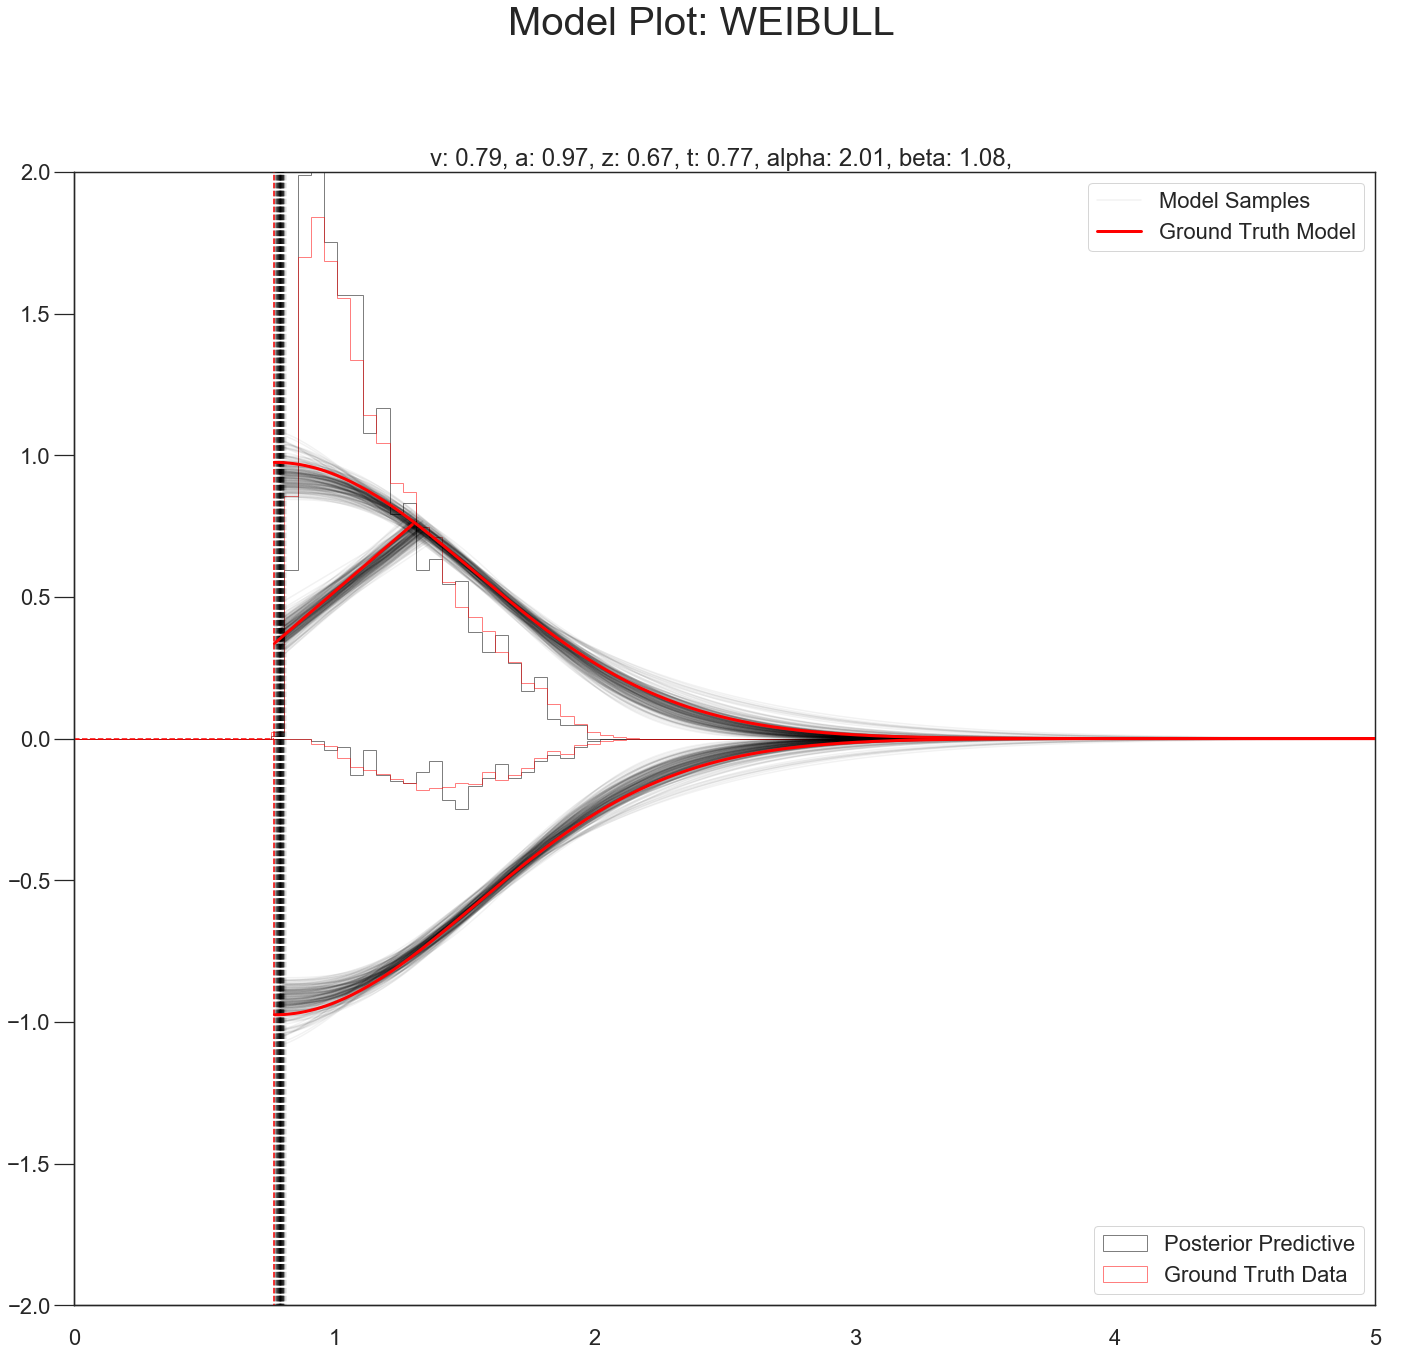

In [177]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths = weibull_params.values[0],
           posterior_samples = hddm_model_single_subject_weibull.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

passed through legend part
0
0


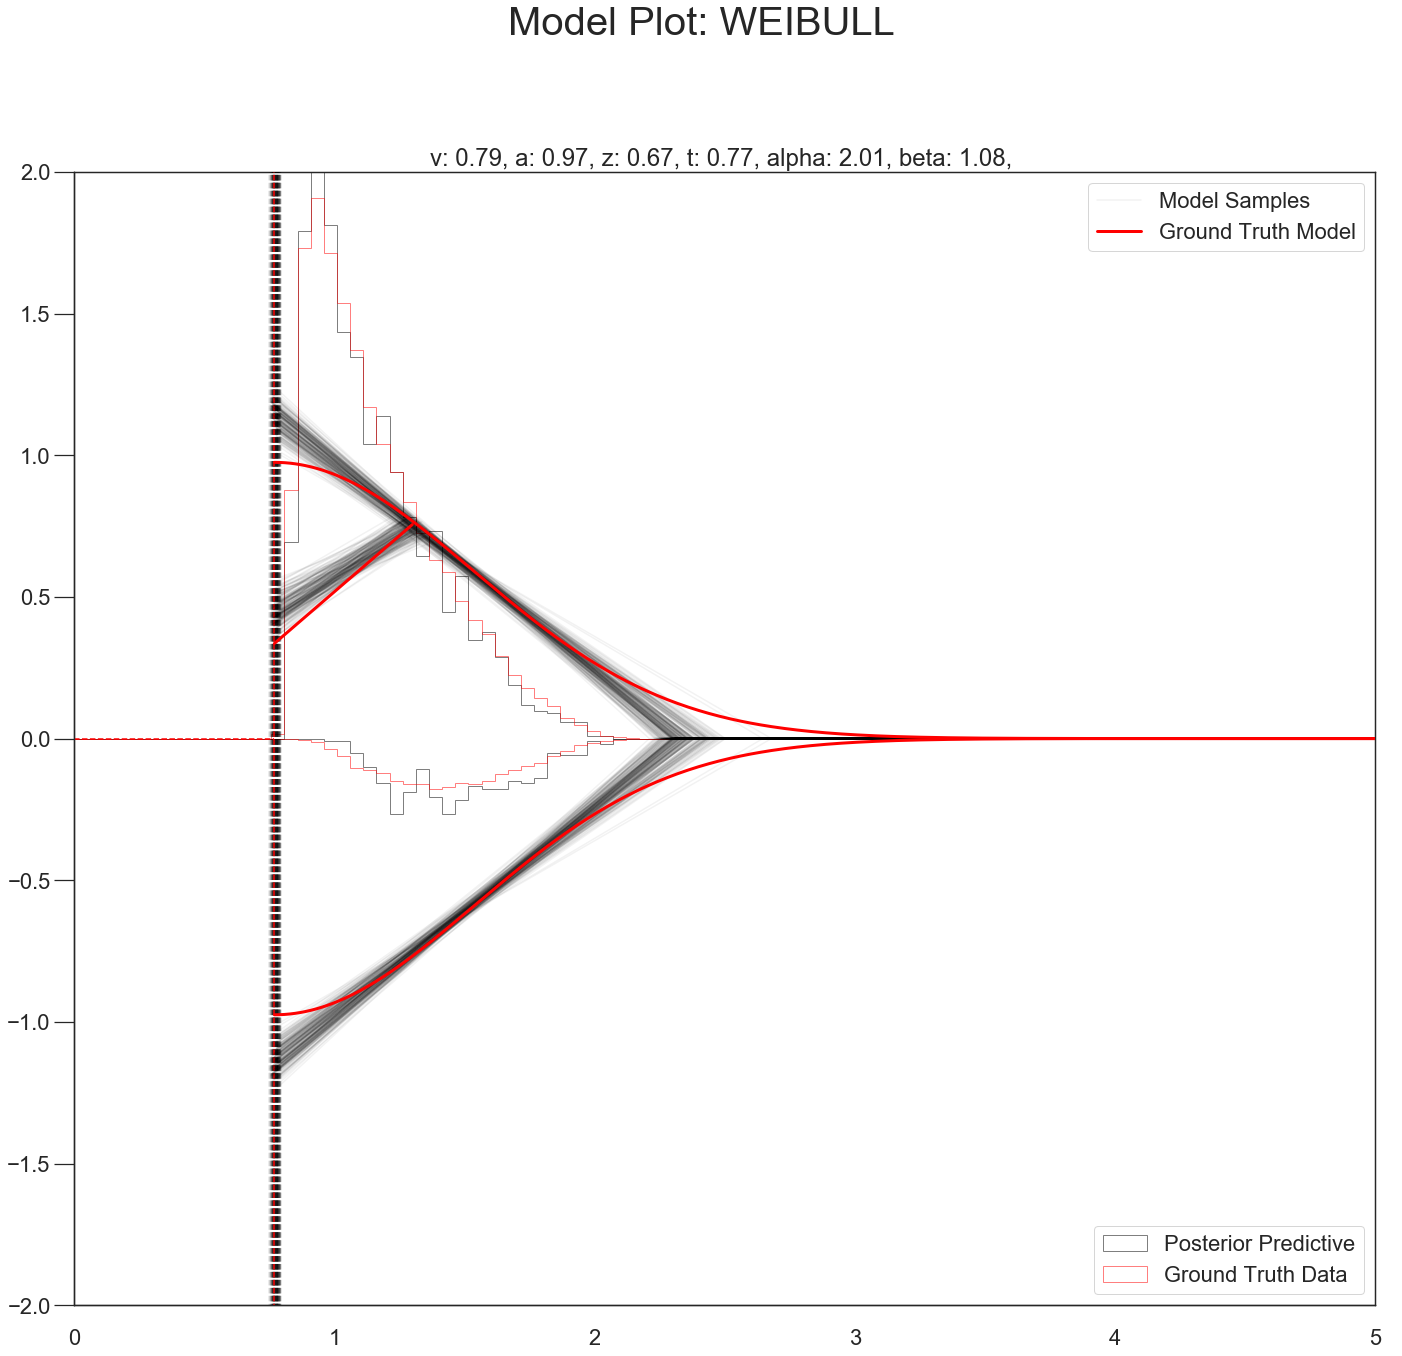

In [178]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths = weibull_params.values[0],
           posterior_samples = hddm_model_single_subject_angle.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'angle',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

passed through legend part
0
0


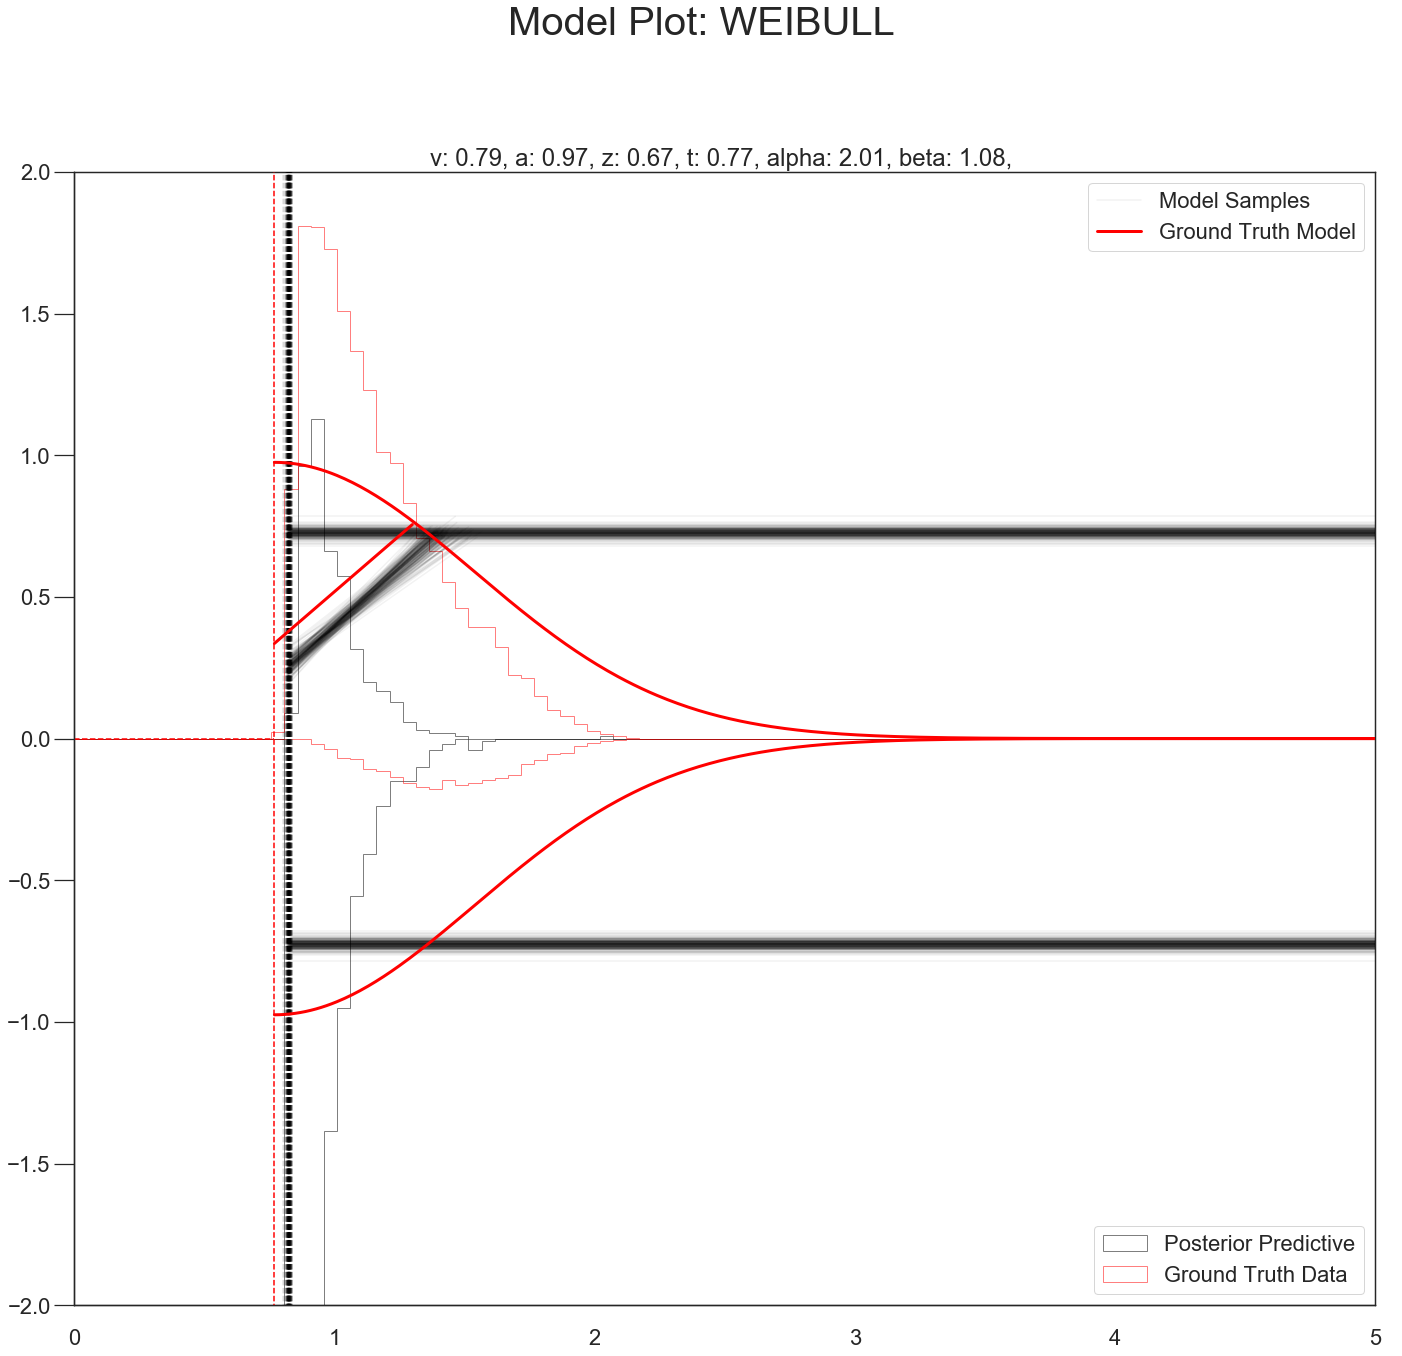

In [179]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths = weibull_params.values[0],
           posterior_samples = hddm_model_single_subject_ddm.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'ddm',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

### Let's compare the DIC's 

In [180]:
hddm_model_single_subject_weibull.dic

504.89051493326826

In [181]:
hddm_model_single_subject_angle.dic

531.1499723307293

In [182]:
hddm_model_single_subject_ddm.dic

681.0696756998698

**Fingers crossed** (this was a random run after all), the DIC usually gives us a result that conforms with the intuition we get from looking at the model plots. 

## Thank you and good luck with your modeling challenge. 

Get in touch with us if you are interested in using the **HDDM neural network extension** for this purpose. 

In [14]:
# pickle.dump([hddm_model_condition.get_traces(), 
#              gt_condition, gt_mat_condition, 
#              hddm_data_condition], 
#              open('condition_weibull_n_1000.pickle', 'wb'))